# mlflow를 활용하여 은행 고객 데이터 분석을 통한 마케팅 타겟 모델 최적화와 상품화

### 실습 모델 구축 목적
    - 은행 고객 데이터를 분석하여 마케팅을 진행할 지 여부를 분석한다.
    - 이를 통해 은행의 마케팅 비용을 효율화하고 비용 절감을 목적으로 한다.

   
### Key Point
    - 데이터를 분석하고 엔지니어링 하는 머신러닝 cycle 과정
    - mlflow를 기반으로 모델 최적화 방법
    - mlflow를 활용한 model 등록
    - model 설명가능성 확인
    - mlflow를 활용한 model deploy와 online inference

In [ ]:
!pip install shap

In [ ]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

# library for sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import shap
%matplotlib inline

## 1. Data Processing 1

### 1-1 Data Load

In [ ]:
# mlflow 실행한 경로와 지금 경로가 동일해야함. (실습의 일관성, 경로가 다르면 문제 생길 수 있음)
!pwd
path_lecture = "./"
random_state = 1234

/Users/stayfoolish/mlflow_practice


In [ ]:
df = pd.read_csv(path_lecture + "data/bank-additional-full.csv", delimiter=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 1-2 Duplicated Data 확인

In [ ]:
print("중복된 항목 수 :", len(df[df.duplicated()]))

중복된 항목 수 : 12


In [ ]:
df[df.duplicated()]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [ ]:
# 중복된 data 제거
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
print("중복된 항목 수 :", len(df[df.duplicated()]))

중복된 항목 수 : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41176 entries, 0 to 41175
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [ ]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

age int64 [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job object ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital object ['married' 'single' 'divorced' 'unknown']
education object ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default object ['no' 'unknown' 'yes']
housing object ['no' 'yes' 'unknown']
loan object ['no' 'yes' 'unknown']
contact object ['telephone' 'cellular']
month object ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week object ['mon' 'tue' 'wed' 'thu' 'fri']
duration int64 [ 261  149  226 ... 1246 1556 1868]
campaign int64 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 

In [ ]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64','int64']).columns)
target_column = "y"
print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

41176
21
11
10


In [ ]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

#### Summary of Data Set
##### - Number of Variables : 21
    categorical variables : 11 (target 포함)
    numeric variables : 10
##### - Number of observations : 41176 (12 duplicated row 삭제 된 수)
##### - Missing Cells : 0 columns
##### - Duplicated Rows : 12

### 2-2 Dependent(종속) Data Explore

In [ ]:
list_categorical_columns.remove(target_column)

In [ ]:
df[target_column].describe()

count     41176
unique        2
top          no
freq      36537
Name: y, dtype: object

In [ ]:
df[target_column].value_counts()

no     36537
yes     4639
Name: y, dtype: int64

<AxesSubplot: xlabel='y', ylabel='count'>

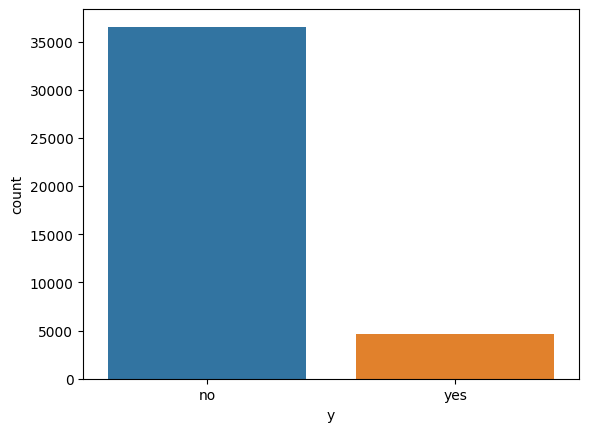

In [ ]:
sns.countplot(x=target_column, data=df)

#### Imbalance data set?
  - 두 개 target class 비중 차이가 있다.
  - sampling과 cost-sensitive learning으로 문제 해결할 수 있다.
  - "Yes" 속성인 데이터들이 유의미한 데이터 분포와 특성을 갖는다면, 추가적인 sampling 없이 모델 학습이 잘 될 수 있다.
  - 독립 변수가 categorical 이 포함된 경우는 one-hot encoding을 진행한 뒤에 sampling(oversampling 혹은 undersampling) 을 해야 한다.
  
##### 1. 데이터 기반 접근 방법
    - Sampling (over sampling 혹은 under sampling)
    (이번 실습에서는 oversampling sampling 중에서 SMOTE, SVMSMOTE / combined sampling 중에서 SMOTEENN 활용)
    https://imbalanced-learn.org/stable/references/index.html#api
##### 2. ML 알고리즘 기반 접근 방법
    - ML 알고리즘 활용 -> ML 학습 시에 class weight를 활용하여 cost-sensitive learning
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

##### 불필요한 컬럼 확인

In [ ]:
df[list_categorical_columns].nunique().sort_values()
# 불필요한 컬럼 보이지 않음

contact         2
default         3
housing         3
loan            3
poutcome        3
marital         4
day_of_week     5
education       8
month          10
job            12
dtype: int64

##### Column별 분포 확인

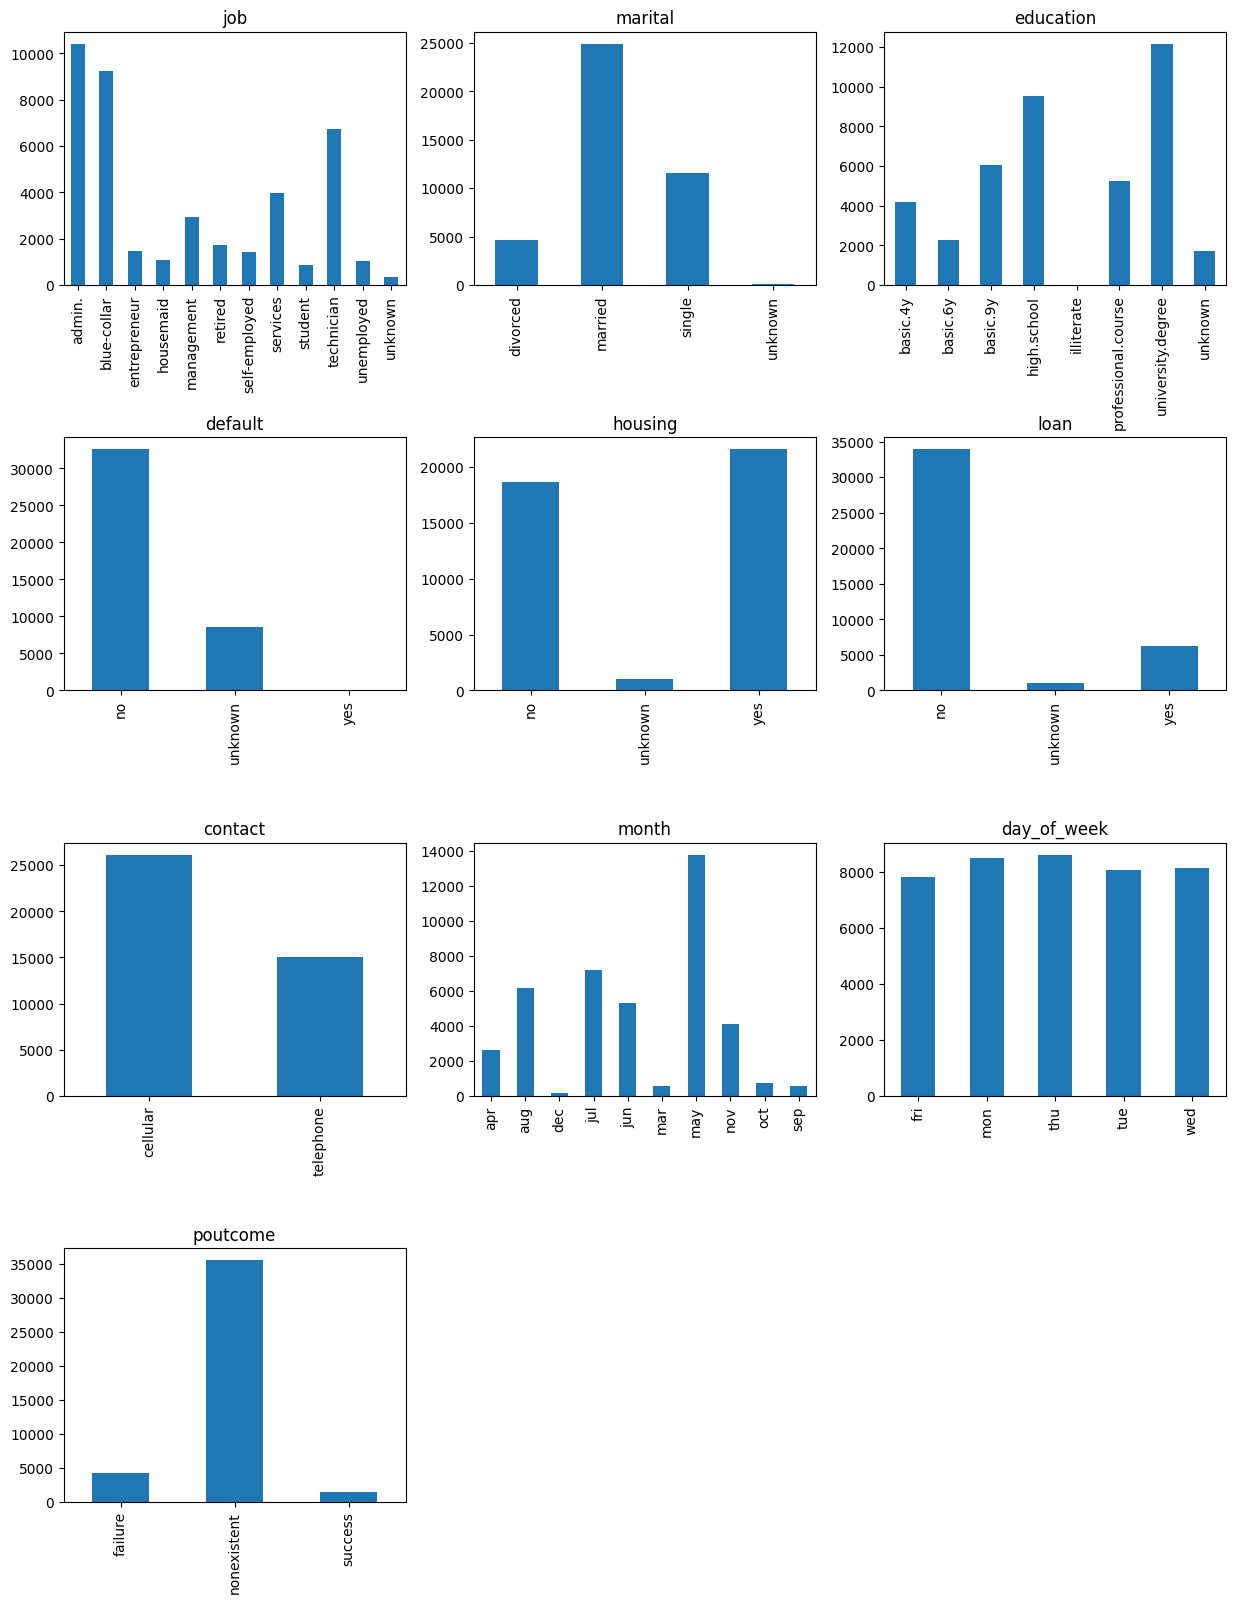

In [ ]:
# cateogircla column 별 분포 확인
plt.figure(figsize=(15,15))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.6, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(4,3,x)
    x = x+1
    df[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)
plt.show()

##### Target column과 categorical column 관계 분포 확인

<AxesSubplot: xlabel='y'>

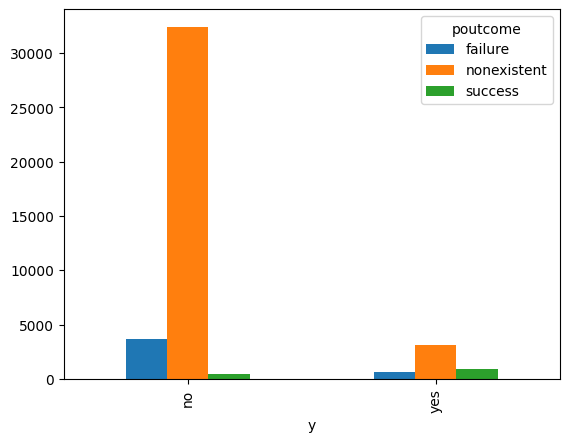

In [ ]:
# categorical column과 dependent data(target column) 분포 분석
df_poutcome_dependent = pd.crosstab(df[target_column], df[list_categorical_columns[-1]])
df_poutcome_dependent.plot(kind='bar')
# 애초에 target_column(y) 비중이 다르기 때문에, 아래와 같이 count 수를 비교하는 것은 데이터 분포를 파악하는데 적합하지 않음

In [ ]:
pd.crosstab(df[target_column], df[list_categorical_columns[-1]])

poutcome,failure,nonexistent,success
y,,,
no,3647,32411,479
yes,605,3140,894


In [ ]:
# 아래와 같은 table을 출력
pd.crosstab(df[target_column], df[list_categorical_columns[-1]], normalize="index")

poutcome,failure,nonexistent,success
y,,,
no,0.099817,0.887073,0.013110
yes,0.130416,0.676870,0.192714


<AxesSubplot: xlabel='y'>

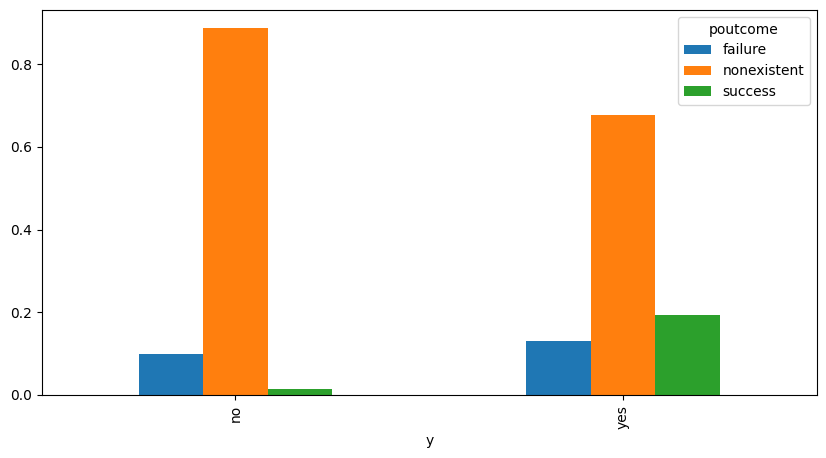

In [ ]:
df_poutcome_dependent_ratio = pd.crosstab(df[target_column], df[list_categorical_columns[-1]], normalize="index")
df_poutcome_dependent_ratio.plot.bar(figsize=(10,5))


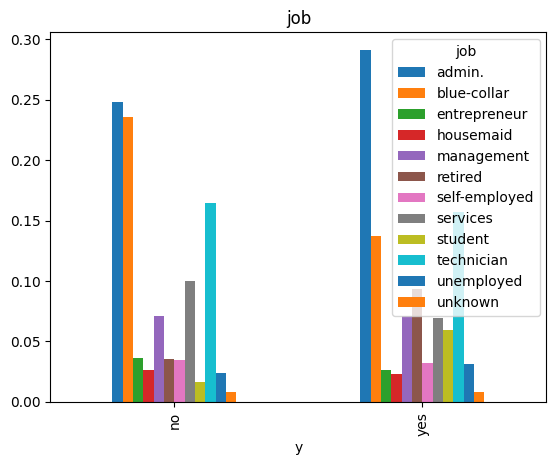

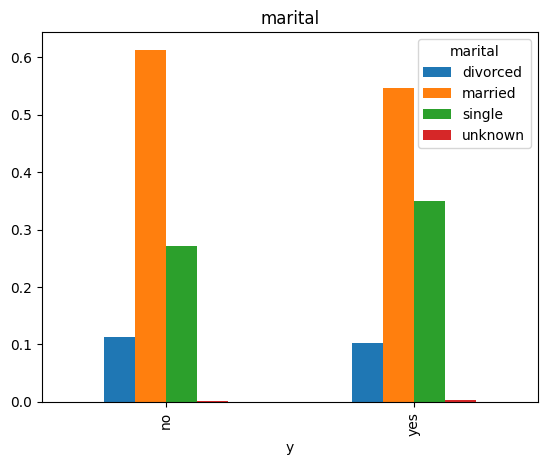

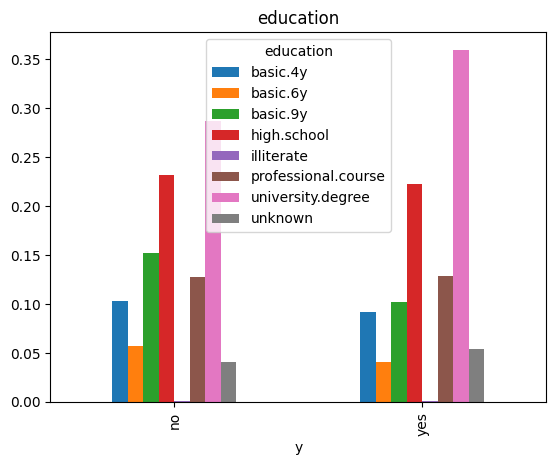

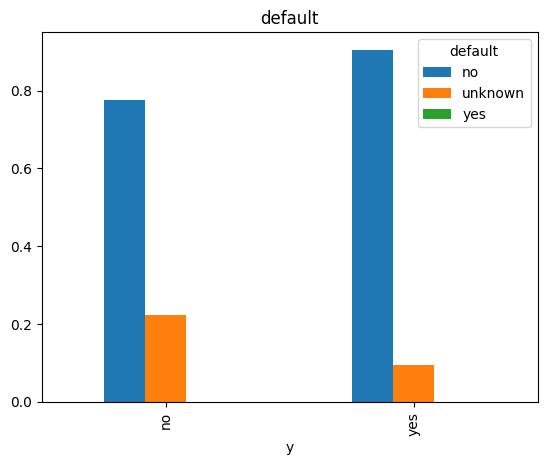

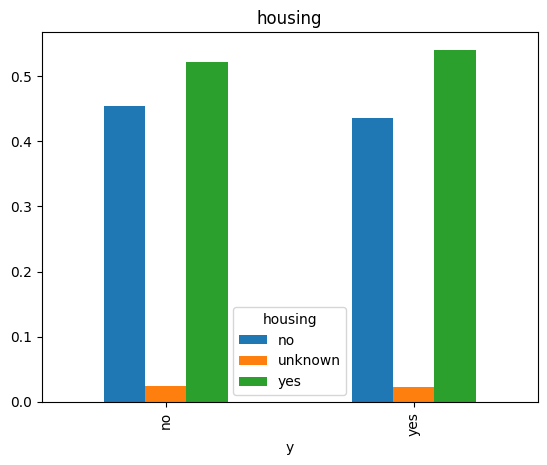

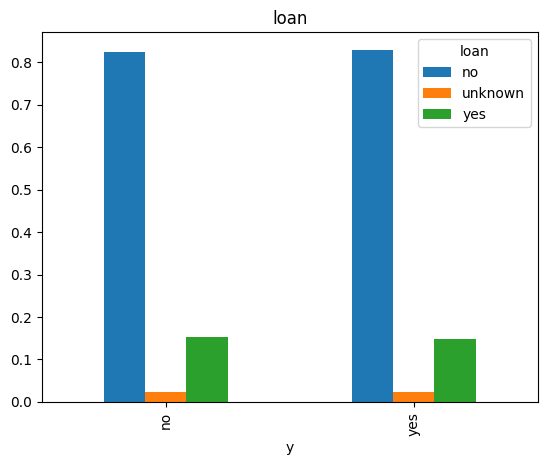

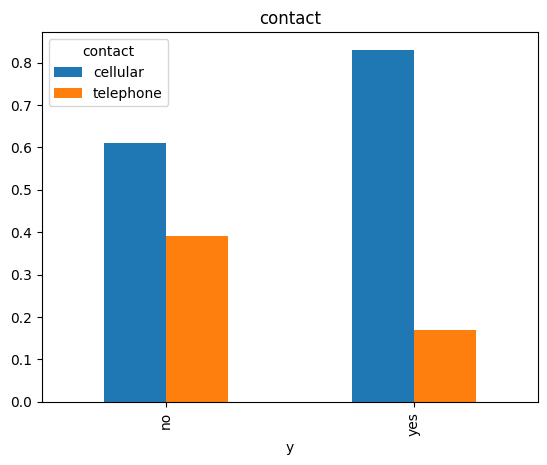

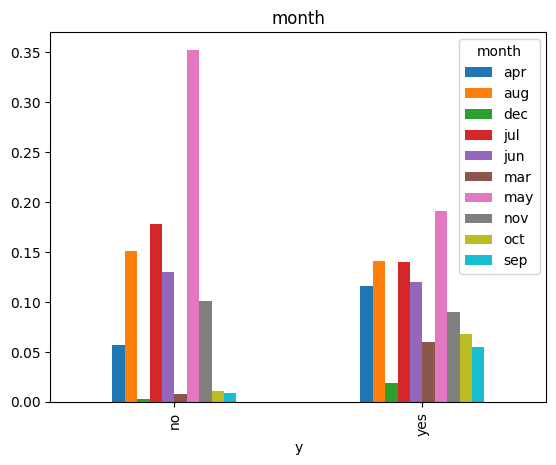

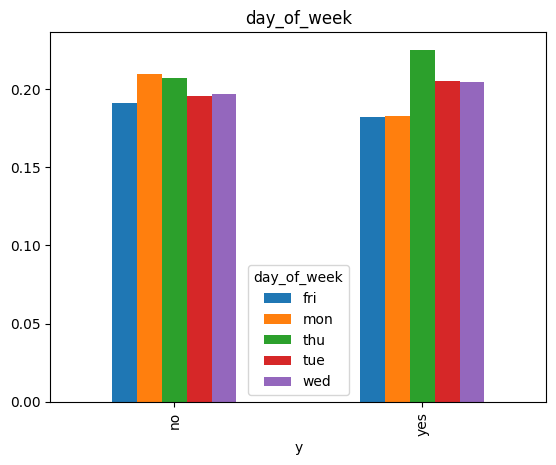

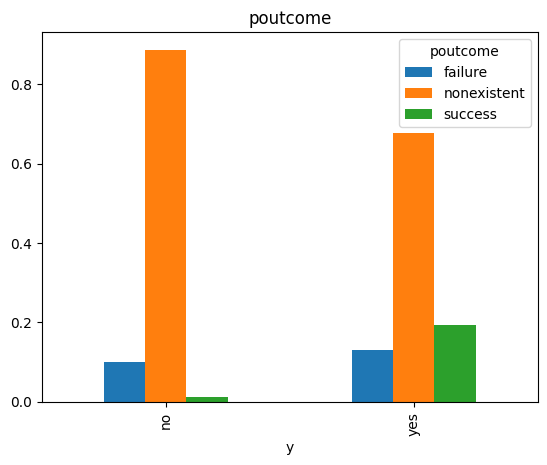

In [ ]:
# 이런 경우에는 비율 데이터를 plot으로 그리면 데이터 분포 이해에 도움.
for column_name in list_categorical_columns:
    pd.crosstab(df[target_column], df[column_name], normalize="index").plot.bar()
    plt.title(column_name)
plt.show()

##### 카이제곱 검정 (chisqaure-test)
*   카이제곱 검정은 두 범주형 변수에 대한 분석 방법.
*   예를 들어, 성별에 따른 선호 영화 장르 비교 문제.
*   본 실습에서는 독립 변수중의 categorical column data와 y(marketing 여부) 간의 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/카이제곱_검정



##### 카이제곱 검정 추가 설명 : 3가지 유형
1.   적합도 검정 (Goodness of fit)
  - 변수 1개
  - 기존에 알려준 기준이 존재하는 검정
  - 예시) 상자 안에 공 3개가 같은 비율로 알려져 있음. 공 100개를 뽑았을 때, 각 색의 비율이 구해짐. -> 기존에 알려진 공 비율 분포를 따르는지 검정
  - 귀무가설 : 변수 X의 관측분포와 기대 분포가 동일
  - 대립가설 : 변수 X의 관측분포와 기대분포가 동일하지 않음

2.   독립성 검정 (Test of independence)
  - 변수 2개
  - 범주형 두 변수가 서로 연관되어 있는지 여부를 검정
  - 예시) 성별과 흡연 여부 관계를 알고 싶어서 200명을 추출하여 조사한 경우.
  - 귀무가설 : 변수 X와 Y는 서로 독립
  - 대립가설 : 변수 X와 Y는 서로 독립이 아님
3.   동질성 검정 (Test of Homogeneity)
  - 변수 2개
  - 범주형 두 변수의 관계를 알기 위한 검정은 아님
  - 각 그룹들이 동질한지 알고 싶은 검정
  - 예시) 남자와 여자 흡연율 차이가 있는지 흡연율을 조사한 후, 두 그룹의 흡연율이 같은지 여부를 검정
  - 귀무가설 : 각 그룹의 확률분포가 동일
  - 대립가설 : 각 그룹의 확률분포가 동일하지 않음




In [ ]:
# 카이제곱 검정 코드
list_meaningful_column_by_chi = []

for column_name in list_categorical_columns:
  statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
  if pvalue <= 0.05:
    list_meaningful_column_by_chi.append(column_name)
  print(column_name, statistic, pvalue)

print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

job 961.7438037353177 3.2684116066165443e-199
marital 122.95931379226256 1.778422500461116e-26
education 192.8485047401879 3.746768377534744e-38
default 406.5560941574606 5.2175408937279634e-89
housing 5.742152842222754 0.05663792749452545
loan 1.0992950447716308 0.5771532081176227
contact 862.0807365848323 1.7187406241263769e-189
month 3103.032672105299 0.0
day_of_week 26.054243692750852 3.085754965631736e-05
poutcome 4230.14342770359 0.0
all categorical columns :  10
selected columns by chi :  8 ['job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'poutcome']


##### Insight
1.   y(종속 변수)와 categorical data 10개 중 8개만이 유의미한 관계를 갖음
2.   housing과 loan는 y와 교호 작용이 없음
2.   유의미한 관계를 갖는 categorical data를 feature selection하여 추후 ML 학습시 활용



#### 2) Numeric Data Analysis

##### 불필요한 컬럼 확인

In [ ]:
df[list_numeric_columns].nunique().sort_values()

previous             8
emp.var.rate        10
nr.employed         11
cons.price.idx      26
cons.conf.idx       26
pdays               27
campaign            42
age                 78
euribor3m          316
duration          1544
dtype: int64

In [ ]:
df[list_numeric_columns].describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


##### Column별 분포 확인

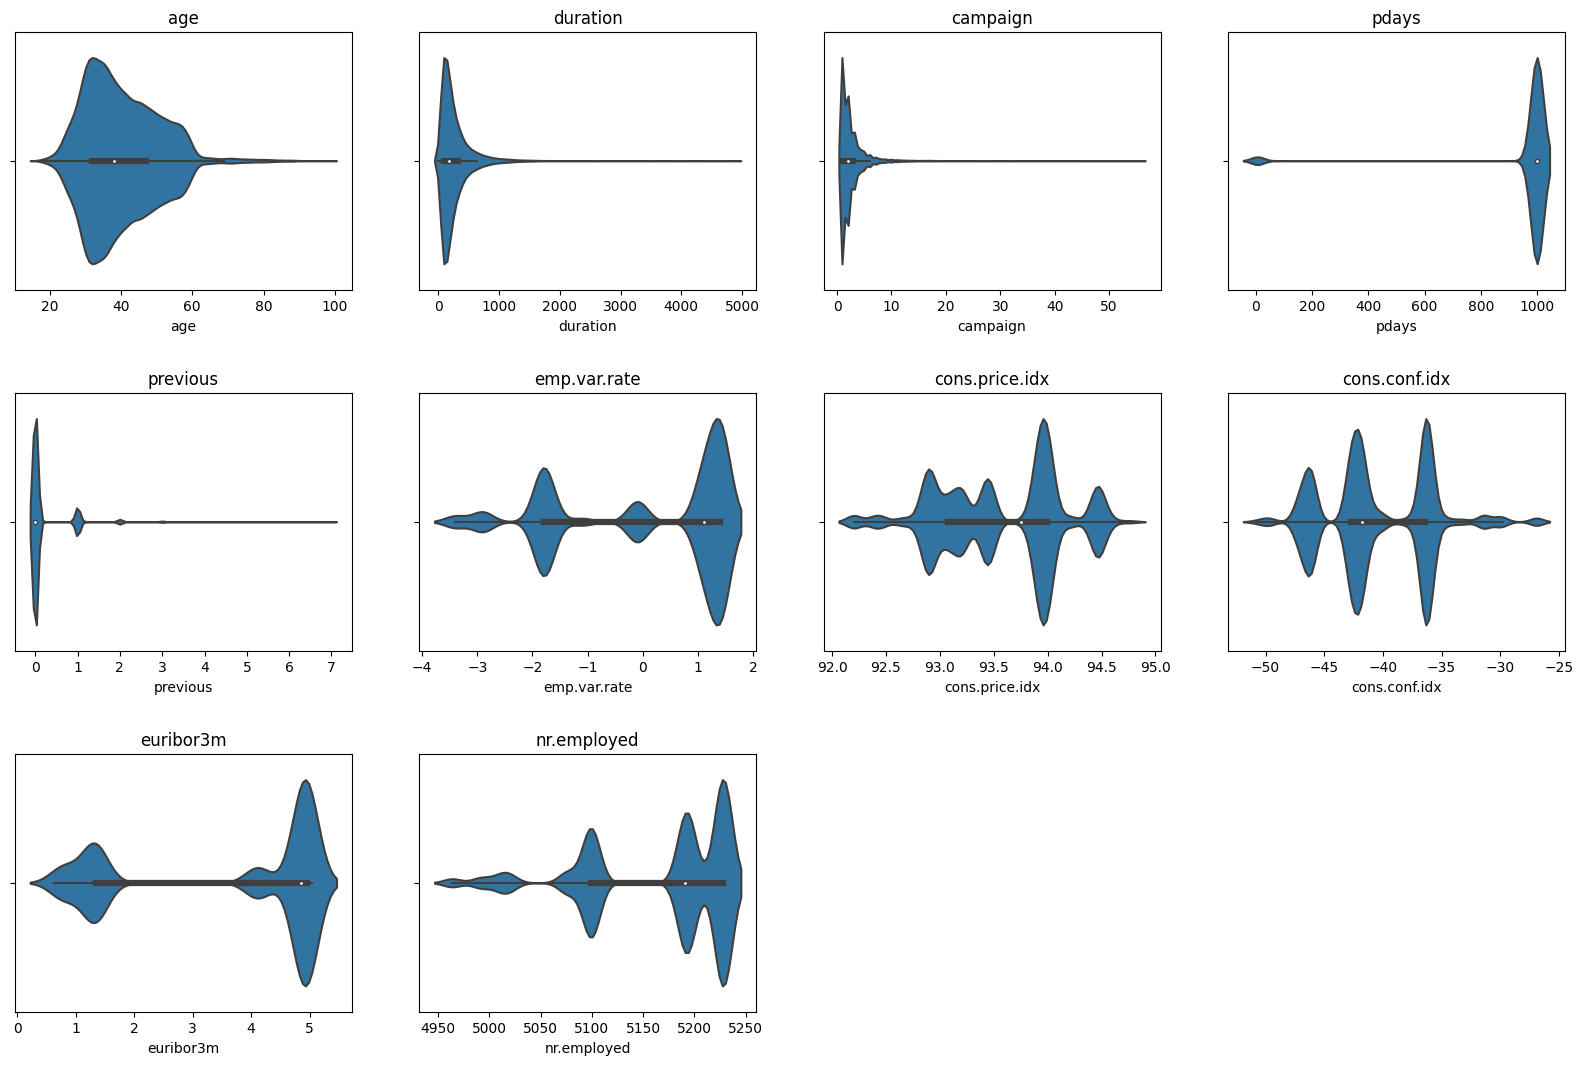

In [ ]:
# numeric column 별 분포 확인
plt.figure(figsize=(20,10))
x = 1

plt.subplots_adjust(top=0.99, bottom = 0.01, hspace = 0.4, wspace=0.2)
for column_name in list_numeric_columns:
  plt.subplot(3,4,x)
  x = x + 1
  sns.violinplot(x=column_name, data=df)
  plt.title(column_name)
plt.show()


In [ ]:
for column_name in list_numeric_columns:
  print(column_name, "skew : ", skew(df[column_name]), "kur : ", kurtosis(df[column_name]) )

# 추후 scaling을 활용한 feature preprocessing의 필요성 확인

age skew :  0.7845316793906337 kur :  0.7908715485573286
duration skew :  3.2626886475171046 kur :  20.241167105999835
campaign skew :  4.76187058291751 kur :  36.96722235388976
pdays skew :  -4.921207099141221 kur :  22.21870880664178
previous skew :  3.8312559388497256 kur :  20.09957712427588
emp.var.rate skew :  -0.7240342146771608 kur :  -1.062714697365619
cons.price.idx skew :  -0.2308444969439891 kur :  -0.8298960161833482
cons.conf.idx skew :  0.3028649665515025 kur :  -0.3591991612497849
euribor3m skew :  -0.7091683770703301 kur :  -1.4067662115952242
nr.employed skew :  -1.0442790133772375 kur :  -0.0036849526898108387


##### Correlation Analysis

<AxesSubplot: >

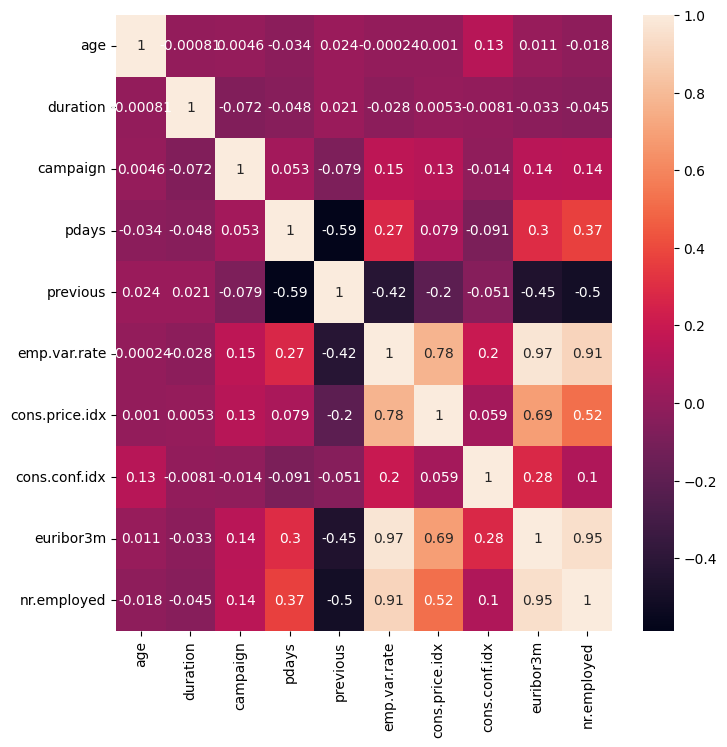

In [ ]:
df_corr = df[list_numeric_columns].corr()
plt.figure(figsize=(8,8))
sns.heatmap(df_corr, annot=True)

In [ ]:
# euribor3m과 emp.var.rate 상관관계가 높음 0.97
# nr.employed와 emp.var.rate 상관관계가 높음 0.91
# emp.var.rate와 cons.price.idx 상관관계가 높음  0.78
# 그 외에도 상관관계 높은 것들이 존재

# 너무 높은 correlation을 갖는 데이터를 삭제. 단, 해당 correlation값을 신뢰할 수 있는지 확인필요
# 기준은 절대값 0.75 이상
index_corr_over_75 = np.where((abs(df_corr)>0.75) & (df_corr != 1))
index_corr_over_75

(array([5, 5, 5, 6, 8, 8, 9, 9]), array([6, 8, 9, 5, 5, 9, 5, 8]))

In [ ]:
len_corr_over_75 = len(index_corr_over_75[0])
left_columns = df_corr.columns[index_corr_over_75[0]]
right_columns = df_corr.columns[index_corr_over_75[1]]
for index in range(len_corr_over_75):
  print(left_columns[index], "<->", right_columns[index])

emp.var.rate <-> cons.price.idx
emp.var.rate <-> euribor3m
emp.var.rate <-> nr.employed
cons.price.idx <-> emp.var.rate
euribor3m <-> emp.var.rate
euribor3m <-> nr.employed
nr.employed <-> emp.var.rate
nr.employed <-> euribor3m


In [ ]:
# correlation이 0.9 이상인 경우의 pvalue 검정
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
list_not_valid = []
for index in range(len_corr_over_75):
    statistic, pvalue = stats.pearsonr(df.loc[:,left_columns[index]], df.loc[:,right_columns[index]])
    print("%s<->%s : %f %f"%(left_columns[index],right_columns[index] , statistic, pvalue))
    if (pvalue > 0.05):
        list_not_valid.append(column_name)
print("end")
print(len(list_not_valid), " is not valids")

emp.var.rate<->cons.price.idx : 0.775293 0.000000
emp.var.rate<->euribor3m : 0.972244 0.000000
emp.var.rate<->nr.employed : 0.906949 0.000000
cons.price.idx<->emp.var.rate : 0.775293 0.000000
euribor3m<->emp.var.rate : 0.972244 0.000000
euribor3m<->nr.employed : 0.945146 0.000000
nr.employed<->emp.var.rate : 0.906949 0.000000
nr.employed<->euribor3m : 0.945146 0.000000
end
0  is not valids


In [ ]:
list_removed_by_correlation = ["emp.var.rate", "euribor3m"]

##### Target Column과 numeric Column 관계 분포 확인

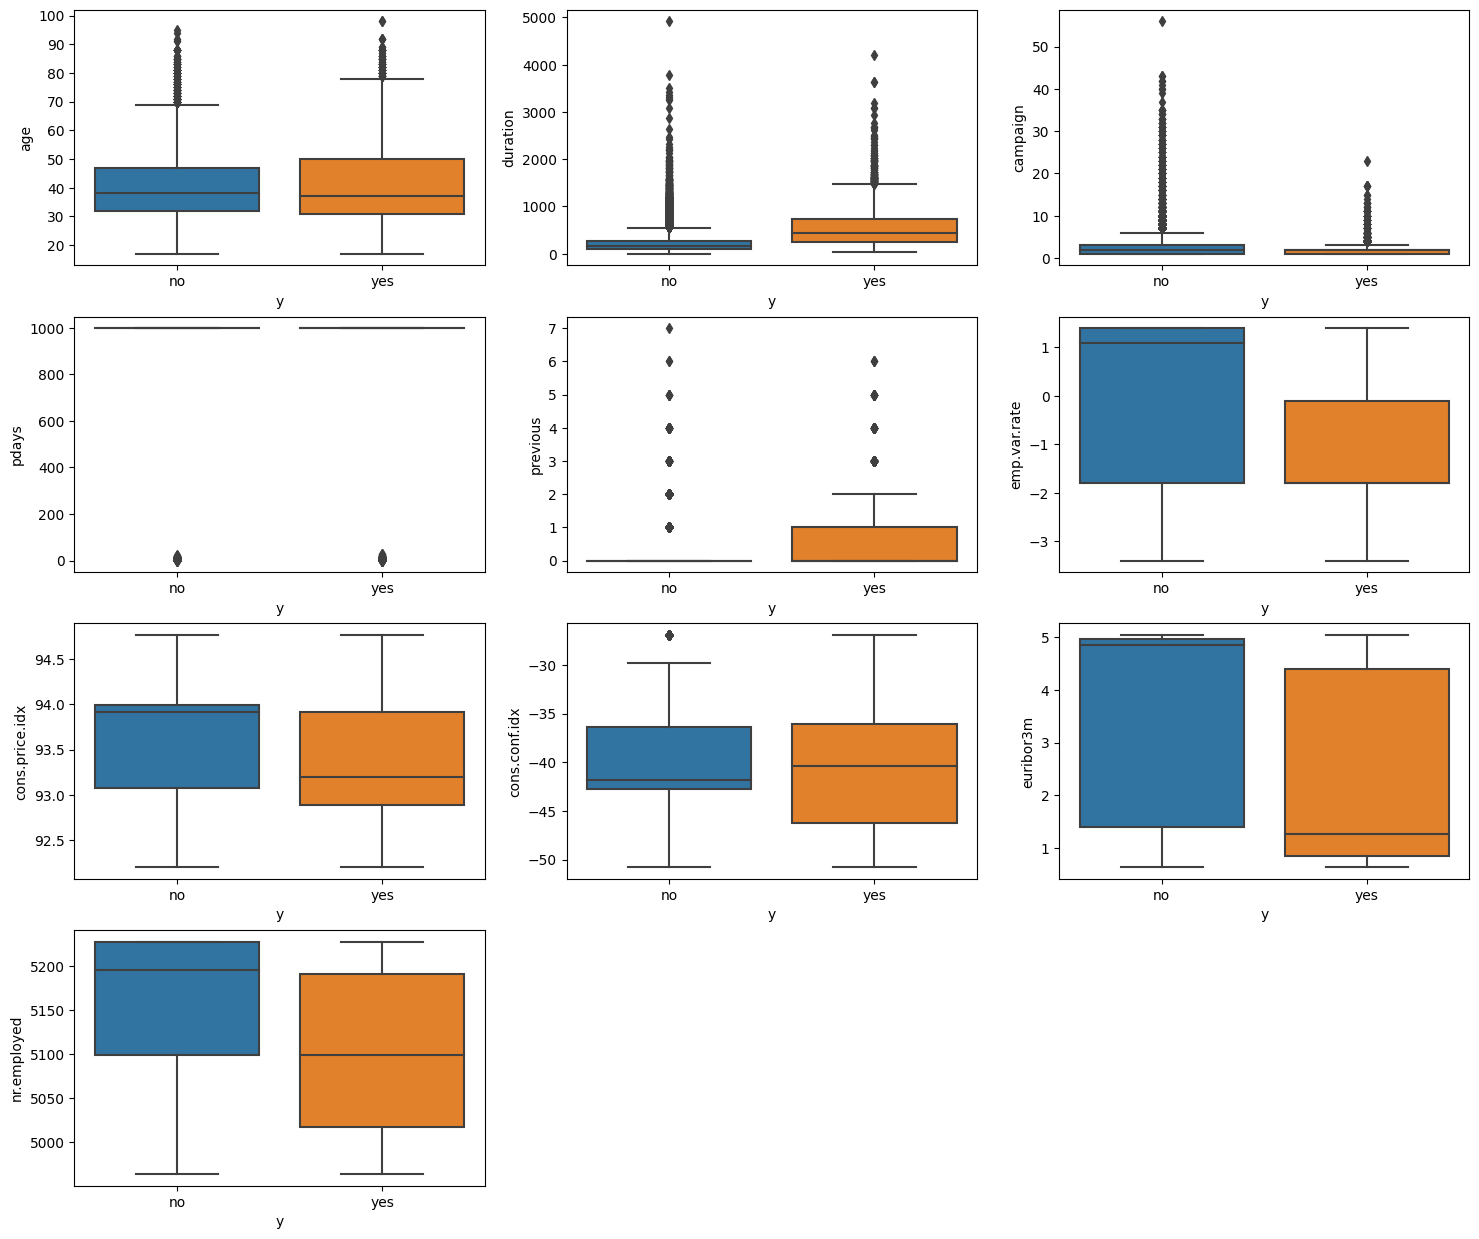

In [ ]:
plt.figure(figsize=(18,12))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(4,3,x)
    x = x + 1
    sns.boxplot(data=df,x=target_column,y=column_name)
plt.show()

# 종속변수에 따른 previous 변수 분포 차이
# 종속변수에 따른 duration 변수 부노 차이

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 y 에 따른 numeric column data 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)





정규성 검정
*   귀무가설 : 모집단의 분포는 정규 분포이다
*   검정 방법 : qqplot, Shpiro-Wilks Test
*   p-value < 0.05이면, 귀무가설 기각 (기각하지 못하여야 정규성을 만족)

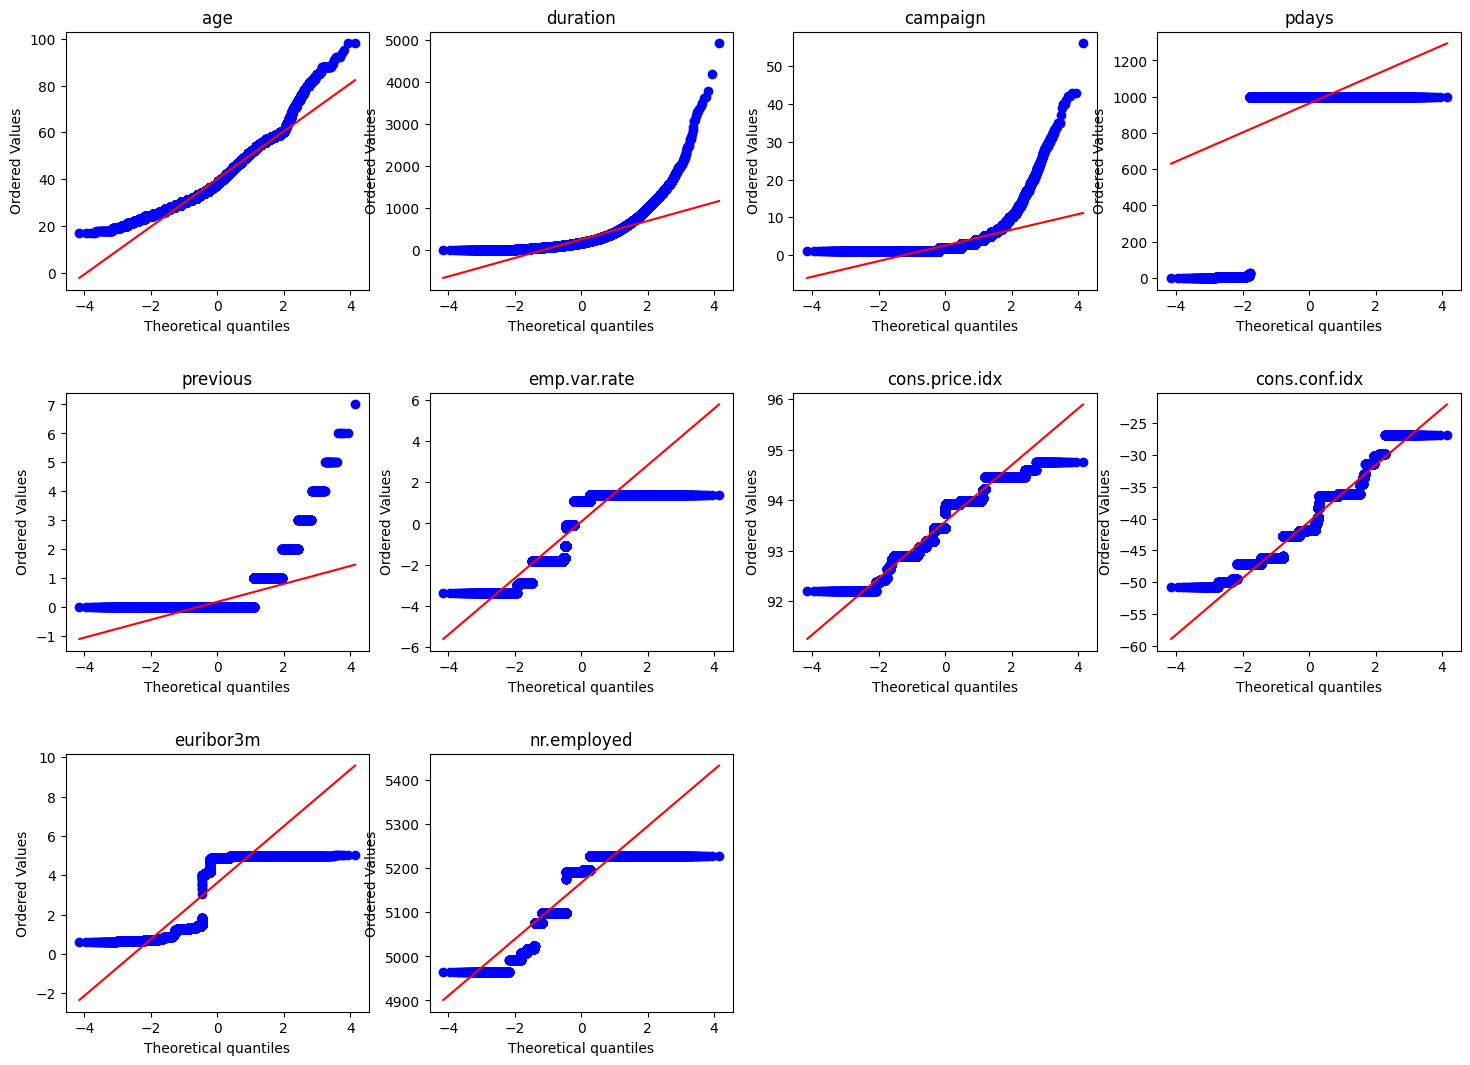

In [ ]:
# numeric column 정규성 확인
plt.figure(figsize=(18,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(3,4,x)
    x = x+1

    stats.probplot(df[column_name], dist=stats.norm, plot=plt)

    plt.title(column_name)
plt.show()

In [ ]:
list_column_normality = []
for column_name in list_numeric_columns:
  statistic, pvalue = stats.shapiro(df[column_name])
  if pvalue > 0.05:
    list_column_normality.append(column_name)
  print(column_name, ", statistic : ",statistic,", pvalue : ", pvalue)
print("정규성 만족하는 column 수 : ", len(list_column_normality))

age , statistic :  0.9572797417640686 , pvalue :  0.0
duration , statistic :  0.7216829657554626 , pvalue :  0.0
campaign , statistic :  0.5578687191009521 , pvalue :  0.0
pdays , statistic :  0.18297964334487915 , pvalue :  0.0
previous , statistic :  0.3913085460662842 , pvalue :  0.0
emp.var.rate , statistic :  0.7621631026268005 , pvalue :  0.0
cons.price.idx , statistic :  0.9339319467544556 , pvalue :  0.0
cons.conf.idx , statistic :  0.9238575100898743 , pvalue :  0.0
euribor3m , statistic :  0.6863112449645996 , pvalue :  0.0
nr.employed , statistic :  0.7877939343452454 , pvalue :  0.0
정규성 만족하는 column 수 :  0


p-value may not be accurate for N > 5000.


정규성 만족하지 못함
*   정규성을 만족하지 못하므로, 등분산성 검정이 필요가 없음 (등분산성은 정규성을 전제)
*   일원분산분석을 통한 numeric data 검정 불가

##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐

In [ ]:
list_meaningful_column_by_kruskall = []

list_target_unique = df[target_column].unique()

for column_name in list_numeric_columns:
  list_by_target_value = []
  for target_value in list_target_unique:
    df_tmp = df[df[target_column]==target_value][column_name].dropna()
    list_by_target_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_target_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ", statistic, ", ", pvalue)
print("all numerical columns : ", len(list_numeric_columns))
print("selected columns by kruskall : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

age ,  5.843156420996497 ,  0.015637749222475184
duration ,  5008.952641567334 ,  0.0
campaign ,  166.83794105975488 ,  3.629350163987945e-38
pdays ,  4348.437887965406 ,  0.0
previous ,  1662.3956401363578 ,  0.0
emp.var.rate ,  2520.7461098911913 ,  0.0
cons.price.idx ,  614.0899232769726 ,  1.4427370342045907e-135
cons.conf.idx ,  69.64459433834713 ,  7.101309014386372e-17
euribor3m ,  2930.314757187436 ,  0.0
nr.employed ,  3318.9556210068745 ,  0.0
all numerical columns :  10
selected columns by kruskall :  10 ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


##### Insight
1.   y(종속 변수)와 numerical data는 모두 유의미한 관계를 갖음 (크루스칼 왈리스 검정)
2.   상관관계가 매우 높은 변수들이 존재하며 2개 데이터를 제거 예정 ("emp.var.rate", "euribor3m")



## 3. Data Processing 2

### 3-1 Missing Values

In [ ]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### 3-2 Feature Selection
*   카이제곱 검정을 통과한 categorical 선택
*   kruskall 검정 통과한 numerical 선택
*   correlation에서 상관관계가 높다고 판단한 numericla data 제거



In [ ]:
list_selected_numerical = list_meaningful_column_by_kruskall.copy()
for column_name in list_removed_by_correlation:
  list_selected_numerical.remove(column_name)

In [ ]:
df_fs = df[list_meaningful_column_by_chi + list_selected_numerical + [target_column]]
df_fs.head(2)

,job,marital,education,default,contact,month,day_of_week,poutcome,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,y
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent,56,261,1,999,0,93.994,-36.4,5191.0,no
1,services,married,high.school,unknown,telephone,may,mon,nonexistent,57,149,1,999,0,93.994,-36.4,5191.0,no


### 3-3 Feature Transformation

In [ ]:
Y = df_fs[target_column]
X = df_fs.drop([target_column], axis=1)

##### Label Encoding

In [ ]:
Y

0         no
1         no
2         no
3         no
4         no
        ... 
41171    yes
41172     no
41173     no
41174    yes
41175     no
Name: y, Length: 41176, dtype: object

In [ ]:
le = LabelEncoder()
le.fit(Y)
Y_encoded = le.transform(Y)

In [ ]:
Y_encoded

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
le.inverse_transform(Y_encoded)

array(['no', 'no', 'no', ..., 'no', 'yes', 'no'], dtype=object)

##### Feature Scaling
*   Standardization과 MinMaxScaling은 다른 것.
*   MinMaxScaling은 [0,1]로 값을 scaling 하는 것 (예 sklearn의 MinMaxScaler())
*   Standardization은 정규분포의 표준화를 활용하여 scaling하는 것 (예 sklearn의 StandardScaler())



In [ ]:
list_categorical_columns = list(df_fs.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df_fs.select_dtypes(include=['float64','int64']).columns)
print(len(list_categorical_columns))
print(len(list_numeric_columns))

9
8


In [ ]:
df_fs.head(1)

,job,marital,education,default,contact,month,day_of_week,poutcome,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,y
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent,56,261,1,999,0,93.994,-36.4,5191.0,no


In [ ]:
scaler = MinMaxScaler()
X.loc[:, list_numeric_columns] = scaler.fit_transform(X[list_numeric_columns])
X.head(1)

,job,marital,education,default,contact,month,day_of_week,poutcome,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent,0.481481,0.05307,0.0,1.0,0.0,0.698753,0.60251,0.859735


##### One-hot Encoding for categorical column data

In [ ]:
X_base = pd.get_dummies(X)
X_base.head(1)

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,job_admin.,job_blue-collar,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.481481,0.05307,0.0,1.0,0.0,0.698753,0.60251,0.859735,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size=0.2, stratify=Y_encoded)

## 4. Model Optimization

#### set mlflow

In [ ]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.create_experiment("bank_marketing_model")


'725520555070266145'

In [ ]:
mlflow.set_experiment("bank_marketing_model")

<Experiment: artifact_location='mlflow-artifacts:/725520555070266145', creation_time=1708137806774, experiment_id='725520555070266145', last_update_time=1708137806774, lifecycle_stage='active', name='bank_marketing_model', tags={}>

### 4-1. Base model without sampling

Split 1


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0  precision, recall, f1score :  (0.7827599809765896, 0.6978699380879219, 0.7298817871827015, None)
0  roc_auc_score :  0.9343447539518246
validation : precision, recall, f1score macro :  (0.792365204455852, 0.7005422140120416, 0.7346521486913464, None)
validation : roc_auc_score :  0.940447289696695
Split 2


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1  precision, recall, f1score :  (0.7886006694550873, 0.7086294818052734, 0.7396660407718885, None)
1  roc_auc_score :  0.9411283071128488
validation : precision, recall, f1score macro :  (0.8002641310089804, 0.7124640804597702, 0.7460054718909122, None)
validation : roc_auc_score :  0.9438126085253762
Split 3
2  precision, recall, f1score :  (0.7753007331482669, 0.7166178051592873, 0.740992106794215, None)
2  roc_auc_score :  0.9363863084007581
validation : precision, recall, f1score macro :  (0.792200102881863, 0.7207854406130267, 0.749554467397334, None)
validation : roc_auc_score :  0.9430504241926656


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


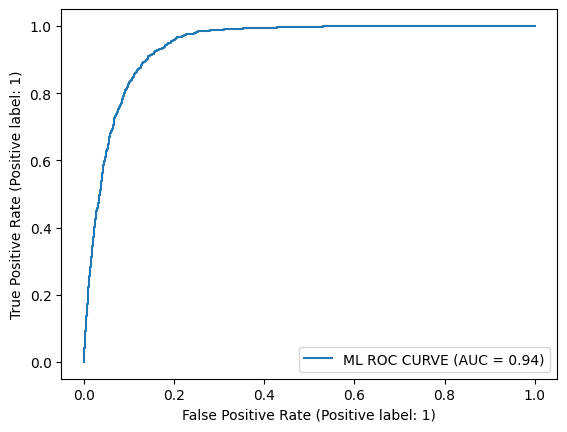

Setuptools is replacing distutils.


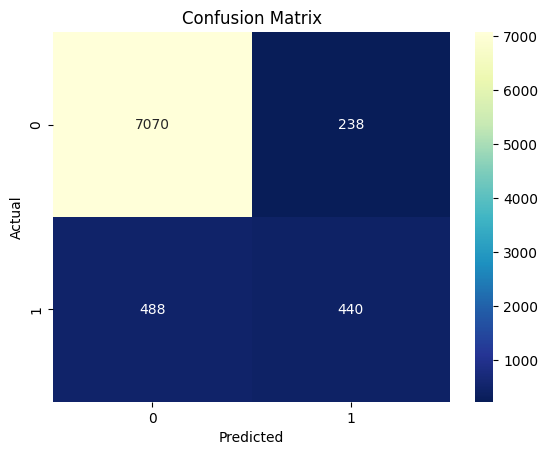

In [ ]:
with mlflow.start_run():
    n_split = 3
    skf = StratifiedKFold(n_splits=n_split)
    skf.get_n_splits(X_base, Y_encoded)

    list_fold_result_test = []
    list_fold_result_validation = []
    list_fold_roc_test = []
    list_fold_roc_validation = []
    num_hidden_layer_sizes = 10
    activation = 'relu'
    learning_rate_init = 0.001

    mlflow.log_param("split num", n_split)
    mlflow.log_param("hidden_layer_sizes", num_hidden_layer_sizes)
    mlflow.log_param("activation", activation)
    mlflow.log_param("learning_rate_init", learning_rate_init)
    mlflow.log_param("sampling", "None")

    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        print("Split " + str(i+1))
        X_train_cv, X_test_cv = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

        # model set
        rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate_init)
        rf_clf.fit(X_train_cv, y_train_cv)

        # model inference on test set
        y_prd_test = rf_clf.predict(X_test_cv)
        y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]

        # score evaluation on test set
        prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average='macro')
        score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average='macro')
        print(i, " precision, recall, f1score : ", prf_score_test)
        print(i, " roc_auc_score : ", score_test)
        list_fold_roc_test.append(score_test)
        list_fold_result_test.append(prf_score_test)

        # model inference on validation data set
        y_prd_validation = rf_clf.predict(X_validation)
        y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]

        # score evaluation on validation data set
        prf_score_validation_macro = precision_recall_fscore_support(y_validation, y_prd_validation, average='macro')
        score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average='macro')
        print("validation : precision, recall, f1score macro : ", prf_score_validation_macro)
        print("validation : roc_auc_score : ", score_validation)
        list_fold_roc_validation.append(score_validation)
        list_fold_result_validation.append(prf_score_validation_macro)


    def get_prf_average(list_of_result):
        pre = 0
        rec = 0
        f1 = 0
        for result in list_fold_result_validation:
            pre += result[0]
            rec += result[1]
            f1 += result[2]
        return pre/n_split, rec/n_split, f1/n_split

    pre, rec, f1 = get_prf_average(list_fold_result_test)
    pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)

    roc = sum(list_fold_roc_test)/n_split
    roc_val = sum(list_fold_roc_validation)/n_split

    mlflow.log_metric("precision_on_test", pre)
    mlflow.log_metric("recall_on_test", rec)
    mlflow.log_metric("f1score_on_test", f1)
    mlflow.log_metric("roc_on_test", roc)


    mlflow.log_metric("precision_on_validation", pre_val)
    mlflow.log_metric("recall_on_validation", rec_val)
    mlflow.log_metric("f1score_on_validation", f1_val)
    mlflow.log_metric("roc_on_validation", roc_val)


    def save_artifact(model, X_validation, y_validation, y_pred):
        roc_plot = RocCurveDisplay.from_estimator(model,X_validation,y_validation,name='ML ROC CURVE')
        plt.savefig('model_roc_plot.png')
        plt.show()
        plt.clf()
        conf_matrix = confusion_matrix(y_validation, y_pred)
        ax=sns.heatmap(conf_matrix,annot=True,fmt='g',cmap='YlGnBu_r')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title("Confusion Matrix")
        plt.savefig('model_conf_matrix.png')
        mlflow.log_artifact('model_roc_plot.png')
        mlflow.log_artifact('model_conf_matrix.png')
    save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)
    mlflow.sklearn.log_model(rf_clf, "model")


mlflow.end_run()


### 4-2 Sampling
*   이번 실습에서는 두 가지 oversampling 기법과 combinedsampling 기법을 활용하고, 3 가지로 만들어진 데이터를 활용하여 Model optimization 진행
*   SMOTE : Synthetic Minority Overf-sampling Technique. minority class에서 synthetic sampling을 생성하는 방법. 특정 minority class A에서 knn 기준으로 가까운 minority class Set K를 생성하고, A와 Set K 사이 간에 새로운 관측치를 생성하는 기법.
*   SMOTEENN : SMOTE(Synthetic Minority Over-sampling Technique) 방법과 ENN(Edited Nearest Neighbours) 방법을 섞은 것



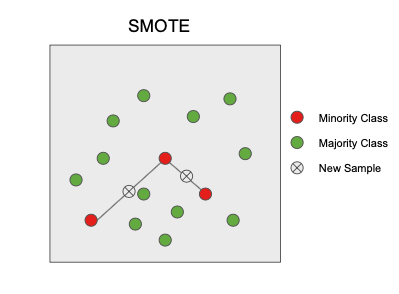

In [ ]:
Image(path_lecture + "img/SMOTE.png")

SMOTE

In [ ]:
sm = SMOTE(random_state=random_state)
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'After sampling for target label')

<Figure size 640x480 with 0 Axes>

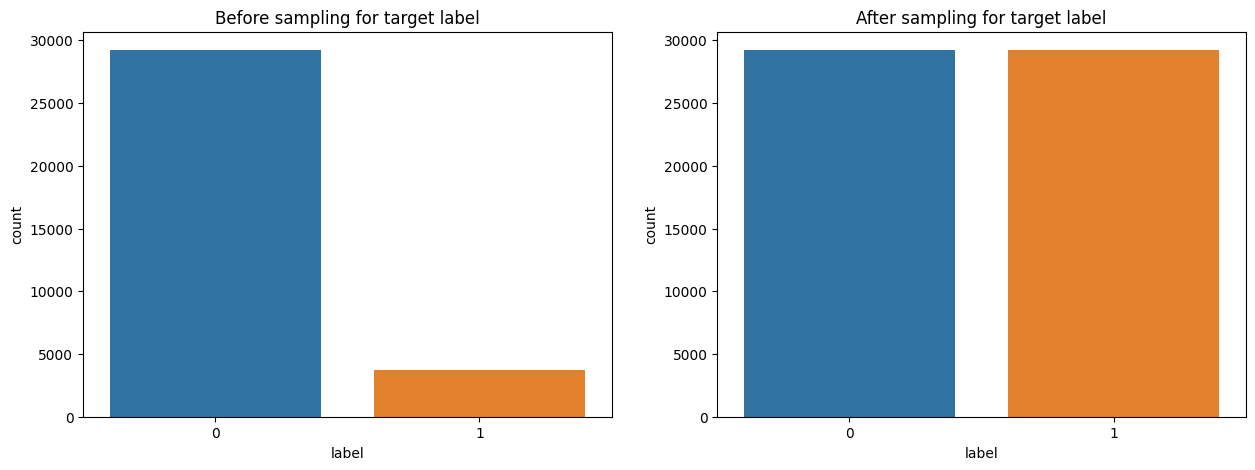

In [ ]:
plt.clf()
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(x="label", data=pd.DataFrame(y_train, columns=["label"]))
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(x="label", data=pd.DataFrame(y_sm_sampling, columns=["label"]))
plt.title("After sampling for target label")

SMOTEENN

In [ ]:
combined_sm = SMOTEENN(random_state=random_state)
X_csm_sampling, y_csm_sampling = combined_sm.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'After sampling for target label')

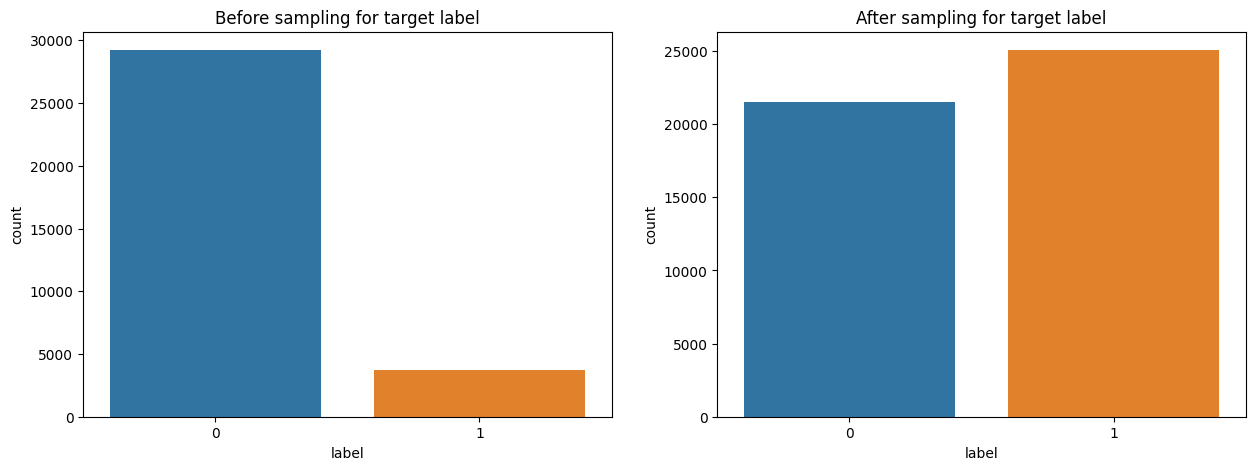

In [ ]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.countplot(x="label", data=pd.DataFrame(y_train, columns=["label"]))
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(x="label", data=pd.DataFrame(y_csm_sampling, columns=["label"]))
plt.title("After sampling for target label")

##### 최종 생성 Feature는 아래와 같은 특성을 가짐
1.   Feature Selection by Chi-test, correlation and kruskal-test
2.   Feature Transformation
3.   Sampling (oversampling, combiedsampling)

##### Feature 종류
1.   X_base, Y_encoded (No sampling, imbalanced data) -> 이미 실험 완료
2.   X_sm_sampling, Y_sm_sampling (smote oversampling)
3.   X_csm_sampling, y_csm_sampling (smoteenn combinedsampling)

### 4-3. model optimization with smote oversampling

Split 1
0  precision, recall, f1score :  (0.8824941286646732, 0.8730370522426357, 0.8722473890068266, None)
0  roc_auc_score :  0.9675027241468779
validation : precision, recall, f1score macro :  (0.7629538730500269, 0.7306547619047619, 0.7452680060690099, None)
validation : roc_auc_score :  0.9234105750901234
Split 2
1  precision, recall, f1score :  (0.9549245172193048, 0.9539669506312224, 0.9539427142379779, None)
1  roc_auc_score :  0.9936630987348899
validation : precision, recall, f1score macro :  (0.7695692124323014, 0.8220186781609196, 0.7922500028511874, None)
validation : roc_auc_score :  0.9427999016193874
Split 3
2  precision, recall, f1score :  (0.9483899274025498, 0.9468336241404085, 0.9467874506767346, None)
2  roc_auc_score :  0.9927568880487168
validation : precision, recall, f1score macro :  (0.7597015527305362, 0.8304341133004927, 0.7884647433906796, None)
validation : roc_auc_score :  0.9422192318762623


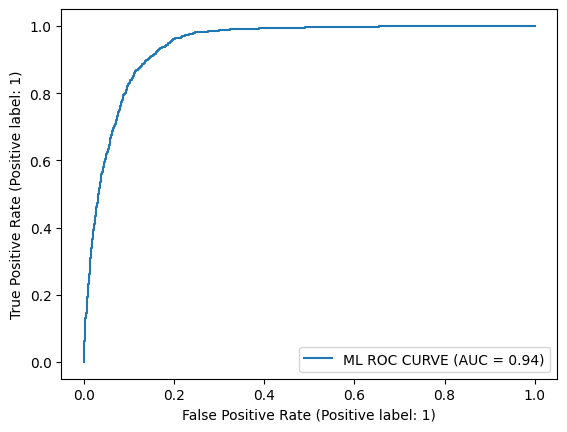

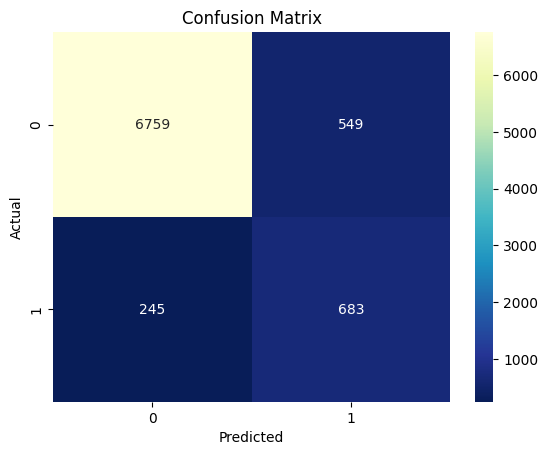

In [ ]:
with mlflow.start_run():
    n_split = 3
    skf = StratifiedKFold(n_splits=n_split)
    skf.get_n_splits(X_base, Y_encoded)

    list_fold_result_test = []
    list_fold_result_validation = []
    list_fold_roc_test = []
    list_fold_roc_validation = []
    num_hidden_layer_sizes = 10
    activation = 'relu'
    learning_rate_init = 0.001

    mlflow.log_param("split num", n_split)
    mlflow.log_param("hidden_layer_sizes", num_hidden_layer_sizes)
    mlflow.log_param("activation", activation)
    mlflow.log_param("learning_rate_init", learning_rate_init)
    mlflow.log_param("sampling", "SMOTE")

    for i, (train_index, test_index) in enumerate(skf.split(X_sm_sampling, y_sm_sampling)):
        print("Split " + str(i+1))
        X_train_cv, X_test_cv = X_sm_sampling.iloc[train_index, :], X_sm_sampling.iloc[test_index, :]
        y_train_cv, y_test_cv = y_sm_sampling[train_index], y_sm_sampling[test_index]

        # model set
        rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate_init)
        rf_clf.fit(X_train_cv, y_train_cv)

        # model inference on test set
        y_prd_test = rf_clf.predict(X_test_cv)
        y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]

        # score evaluation on test set
        prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average='macro')
        score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average='macro')
        print(i, " precision, recall, f1score : ", prf_score_test)
        print(i, " roc_auc_score : ", score_test)
        list_fold_roc_test.append(score_test)
        list_fold_result_test.append(prf_score_test)

        # model inference on validation data set
        y_prd_validation = rf_clf.predict(X_validation)
        y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]

        # score evaluation on validation data set
        prf_score_validation_macro = precision_recall_fscore_support(y_validation, y_prd_validation, average='macro')
        score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average='macro')
        print("validation : precision, recall, f1score macro : ", prf_score_validation_macro)
        print("validation : roc_auc_score : ", score_validation)
        list_fold_roc_validation.append(score_validation)
        list_fold_result_validation.append(prf_score_validation_macro)


    def get_prf_average(list_of_result):
        pre = 0
        rec = 0
        f1 = 0
        for result in list_fold_result_validation:
            pre += result[0]
            rec += result[1]
            f1 += result[2]
        return pre/n_split, rec/n_split, f1/n_split

    pre, rec, f1 = get_prf_average(list_fold_result_test)
    pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)

    roc = sum(list_fold_roc_test)/n_split
    roc_val = sum(list_fold_roc_validation)/n_split

    mlflow.log_metric("precision_on_test", pre)
    mlflow.log_metric("recall_on_test", rec)
    mlflow.log_metric("f1score_on_test", f1)
    mlflow.log_metric("roc_on_test", roc)


    mlflow.log_metric("precision_on_validation", pre_val)
    mlflow.log_metric("recall_on_validation", rec_val)
    mlflow.log_metric("f1score_on_validation", f1_val)
    mlflow.log_metric("roc_on_validation", roc_val)


    def save_artifact(model, X_validation, y_validation, y_pred):
        roc_plot = RocCurveDisplay.from_estimator(model,X_validation,y_validation,name='ML ROC CURVE')
        plt.savefig('model_roc_plot.png')
        plt.show()
        plt.clf()
        conf_matrix = confusion_matrix(y_validation, y_pred)
        ax=sns.heatmap(conf_matrix,annot=True,fmt='g',cmap='YlGnBu_r')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title("Confusion Matrix")
        plt.savefig('model_conf_matrix.png')
        mlflow.log_artifact('model_roc_plot.png')
        mlflow.log_artifact('model_conf_matrix.png')
    save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)
    mlflow.sklearn.log_model(rf_clf, "model")



mlflow.end_run()


### 4-5. model optimization with smoteenn combined sampling

Split 1


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0  precision, recall, f1score :  (0.9434826186567724, 0.9459265326446323, 0.9439167935072261, None)
0  roc_auc_score :  0.9853641531162572
validation : precision, recall, f1score macro :  (0.751170652191862, 0.8139966475095786, 0.7771238055969136, None)
validation : roc_auc_score :  0.9210718237453523
Split 2


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1  precision, recall, f1score :  (0.9753528722157092, 0.9735006133100901, 0.9743044878827127, None)
1  roc_auc_score :  0.9975145960594676
validation : precision, recall, f1score macro :  (0.7351121377357412, 0.8520970169677067, 0.7742103643056948, None)
validation : roc_auc_score :  0.9357715564426325
Split 3
2  precision, recall, f1score :  (0.9737863699281999, 0.9715166173974147, 0.9724762401960253, None)
2  roc_auc_score :  0.9962631119023301
validation : precision, recall, f1score macro :  (0.7342089712058683, 0.8512845511767926, 0.7732372962064364, None)
validation : roc_auc_score :  0.9367311802842421


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


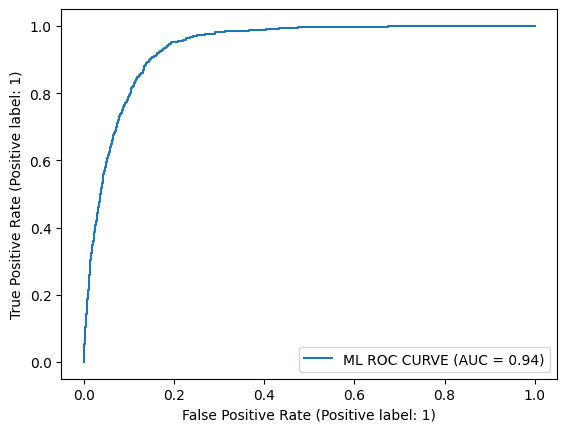

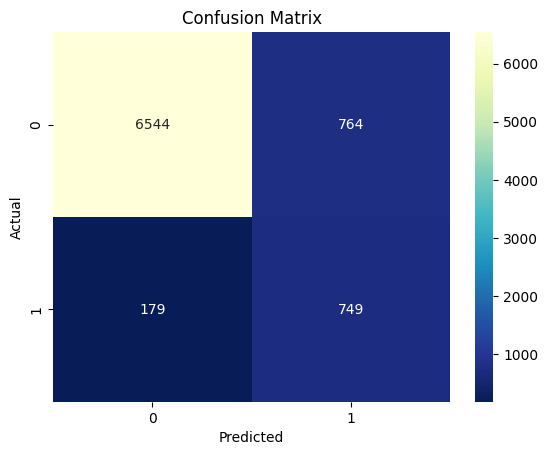

In [ ]:
with mlflow.start_run():
    n_split = 3
    skf = StratifiedKFold(n_splits=n_split)
    skf.get_n_splits(X_base, Y_encoded)

    list_fold_result_test = []
    list_fold_result_validation = []
    list_fold_roc_test = []
    list_fold_roc_validation = []
    num_hidden_layer_sizes = 10
    activation = 'relu'
    learning_rate_init = 0.001

    mlflow.log_param("split num", n_split)
    mlflow.log_param("hidden_layer_sizes", num_hidden_layer_sizes)
    mlflow.log_param("activation", activation)
    mlflow.log_param("learning_rate_init", learning_rate_init)
    mlflow.log_param("sampling", "SMOTEENN")
    for i, (train_index, test_index) in enumerate(skf.split(X_csm_sampling, y_csm_sampling)):
        print("Split " + str(i+1))
        X_train_cv, X_test_cv = X_csm_sampling.iloc[train_index, :], X_csm_sampling.iloc[test_index, :]
        y_train_cv, y_test_cv = y_csm_sampling[train_index], y_csm_sampling[test_index]

        # model set
        rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate_init)
        rf_clf.fit(X_train_cv, y_train_cv)

        # model inference on test set
        y_prd_test = rf_clf.predict(X_test_cv)
        y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]

        # score evaluation on test set
        prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average='macro')
        score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average='macro')
        print(i, " precision, recall, f1score : ", prf_score_test)
        print(i, " roc_auc_score : ", score_test)
        list_fold_roc_test.append(score_test)
        list_fold_result_test.append(prf_score_test)

        # model inference on validation data set
        y_prd_validation = rf_clf.predict(X_validation)
        y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]

        # score evaluation on validation data set
        prf_score_validation_macro = precision_recall_fscore_support(y_validation, y_prd_validation, average='macro')
        score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average='macro')
        print("validation : precision, recall, f1score macro : ", prf_score_validation_macro)
        print("validation : roc_auc_score : ", score_validation)
        list_fold_roc_validation.append(score_validation)
        list_fold_result_validation.append(prf_score_validation_macro)


    def get_prf_average(list_of_result):
        pre = 0
        rec = 0
        f1 = 0
        for result in list_fold_result_validation:
            pre += result[0]
            rec += result[1]
            f1 += result[2]
        return pre/n_split, rec/n_split, f1/n_split

    pre, rec, f1 = get_prf_average(list_fold_result_test)
    pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)

    roc = sum(list_fold_roc_test)/n_split
    roc_val = sum(list_fold_roc_validation)/n_split

    mlflow.log_metric("precision_on_test", pre)
    mlflow.log_metric("recall_on_test", rec)
    mlflow.log_metric("f1score_on_test", f1)
    mlflow.log_metric("roc_on_test", roc)


    mlflow.log_metric("precision_on_validation", pre_val)
    mlflow.log_metric("recall_on_validation", rec_val)
    mlflow.log_metric("f1score_on_validation", f1_val)
    mlflow.log_metric("roc_on_validation", roc_val)


    def save_artifact(model, X_validation, y_validation, y_pred):
        roc_plot = RocCurveDisplay.from_estimator(model,X_validation,y_validation,name='ML ROC CURVE')
        plt.savefig('model_roc_plot.png')
        plt.show()
        plt.clf()
        conf_matrix = confusion_matrix(y_validation, y_pred)
        ax=sns.heatmap(conf_matrix,annot=True,fmt='g',cmap='YlGnBu_r')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title("Confusion Matrix")
        plt.savefig('model_conf_matrix.png')
        mlflow.log_artifact('model_roc_plot.png')
        mlflow.log_artifact('model_conf_matrix.png')
    save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)
    mlflow.sklearn.log_model(rf_clf, "model")


mlflow.end_run()


### 4.6 Model Optimization with hyper-parameters

Split 1


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0  precision, recall, f1score :  (0.9407733745008009, 0.9433230676795126, 0.9409741985683382, None)
0  roc_auc_score :  0.9827543822210406
validation : precision, recall, f1score macro :  (0.747015445764641, 0.7993979200875753, 0.7692918913128386, None)
validation : roc_auc_score :  0.9091588044750203
Split 2


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1  precision, recall, f1score :  (0.9776831143649918, 0.9767461654273011, 0.9771796518317261, None)
1  roc_auc_score :  0.997831227152681
validation : precision, recall, f1score macro :  (0.7379277610294009, 0.8323156130268199, 0.7724126083397373, None)
validation : roc_auc_score :  0.9329658215842818
Split 3
2  precision, recall, f1score :  (0.9726709987579554, 0.9710766532845396, 0.9717799113045689, None)
2  roc_auc_score :  0.9967385350623913
validation : precision, recall, f1score macro :  (0.7420285963892419, 0.847718253968254, 0.7794126407625197, None)
validation : roc_auc_score :  0.9393269421323822


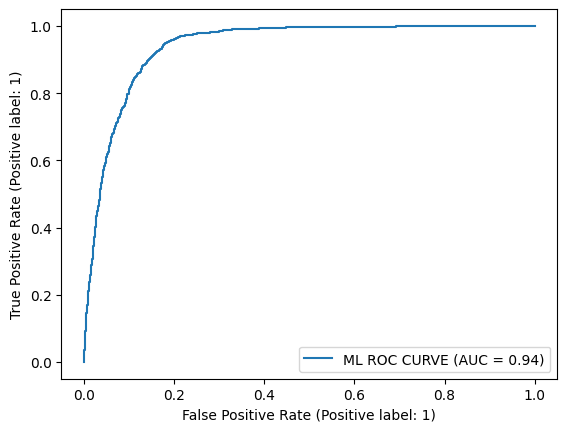

Split 1
0  precision, recall, f1score :  (0.9418790973189457, 0.9442632518286864, 0.9423599856258753, None)
0  roc_auc_score :  0.9869242202033458
validation : precision, recall, f1score macro :  (0.7355558648002483, 0.8045036261631089, 0.7629889474094401, None)
validation : roc_auc_score :  0.9206456847007531
Split 2
1  precision, recall, f1score :  (0.9744478643294456, 0.9719480199179309, 0.9729904913525824, None)
1  roc_auc_score :  0.9971148868395839
validation : precision, recall, f1score macro :  (0.727355336639202, 0.8535765599343186, 0.7671696758647348, None)
validation : roc_auc_score :  0.9335607942641978
Split 3
2  precision, recall, f1score :  (0.9710019209819394, 0.9666978154641117, 0.9683286918561002, None)
2  roc_auc_score :  0.996521660156054
validation : precision, recall, f1score macro :  (0.7269069566857415, 0.8624281609195402, 0.7679413889478106, None)
validation : roc_auc_score :  0.9355925485533096


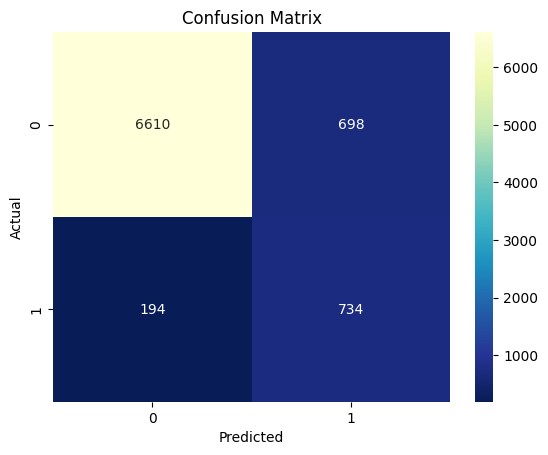

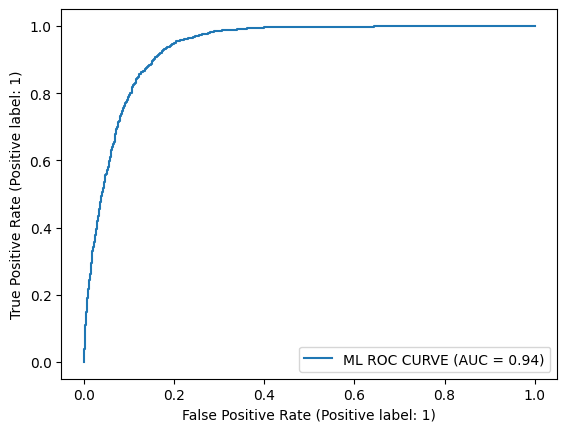

Split 1
0  precision, recall, f1score :  (0.9463197393444268, 0.9480363000031897, 0.9469397708326683, None)
0  roc_auc_score :  0.9862015239130879
validation : precision, recall, f1score macro :  (0.7264240195323276, 0.8283388067870826, 0.7617977534797156, None)
validation : roc_auc_score :  0.9173518805560275
Split 2
1  precision, recall, f1score :  (0.9699136329171045, 0.9686064274844064, 0.9691938338589999, None)
1  roc_auc_score :  0.9964172474461649
validation : precision, recall, f1score macro :  (0.7363683835041788, 0.8592210591133005, 0.7766408921939542, None)
validation : roc_auc_score :  0.9327449370552819
Split 3
2  precision, recall, f1score :  (0.9651683247292234, 0.9648653643083862, 0.9650126724866235, None)
2  roc_auc_score :  0.9961569432943356
validation : precision, recall, f1score macro :  (0.7425973966606859, 0.8380541871921182, 0.7776288804081062, None)
validation : roc_auc_score :  0.9361732182964346


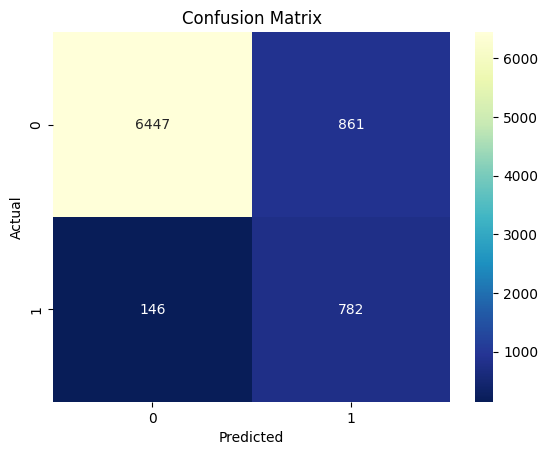

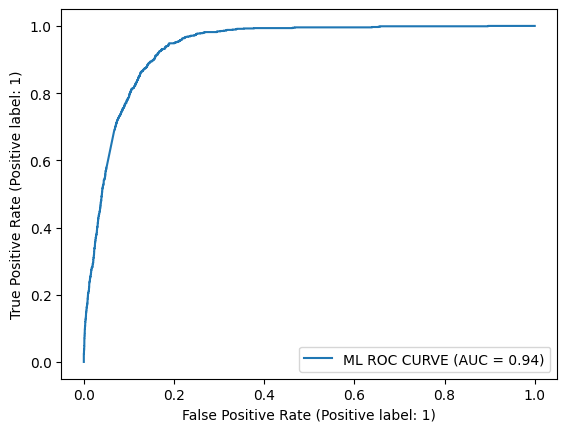

Split 1
0  precision, recall, f1score :  (0.9466359282431009, 0.9488196867000394, 0.9472396203193418, None)
0  roc_auc_score :  0.9847847749356831
validation : precision, recall, f1score macro :  (0.7426573759130811, 0.8099856321839081, 0.7698253152729957, None)
validation : roc_auc_score :  0.9103533208765074
Split 2


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1  precision, recall, f1score :  (0.9787265197363046, 0.9765506482295951, 0.9774775346149096, None)
1  roc_auc_score :  0.9981379322448165
validation : precision, recall, f1score macro :  (0.7351132838851071, 0.8437072386425835, 0.7725764385071451, None)
validation : roc_auc_score :  0.9288179699148783
Split 3
2  precision, recall, f1score :  (0.9773960390065091, 0.9747459514835153, 0.9758438342494554, None)
2  roc_auc_score :  0.9975433912051788
validation : precision, recall, f1score macro :  (0.7337392413159181, 0.8431598932676518, 0.771254737540269, None)
validation : roc_auc_score :  0.931459442179567


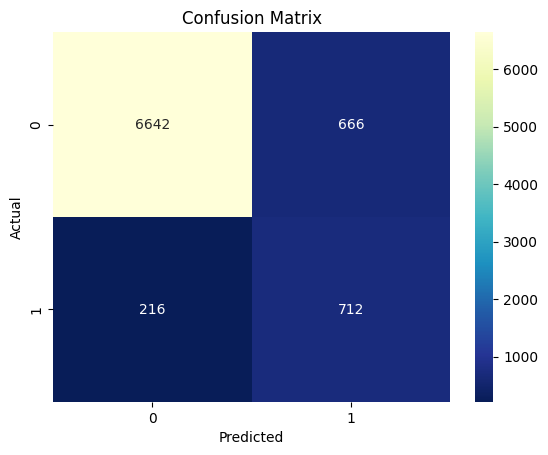

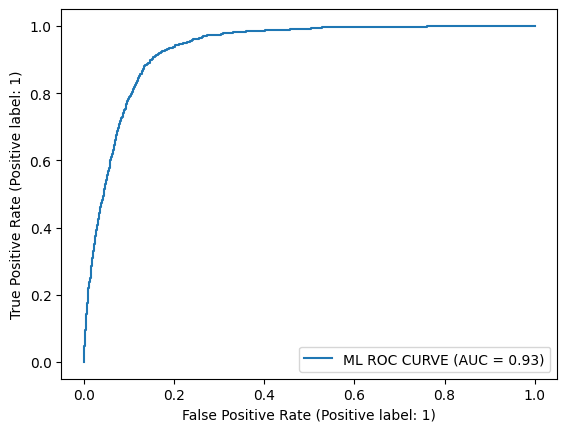

Split 1
0  precision, recall, f1score :  (0.9418532793789138, 0.9444352469061905, 0.941586428536306, None)
0  roc_auc_score :  0.9853194610878737
validation : precision, recall, f1score macro :  (0.751209188519603, 0.7707991242474002, 0.7604461962366735, None)
validation : roc_auc_score :  0.9074008703263311
Split 2
1  precision, recall, f1score :  (0.9791692280410753, 0.9775554097740181, 0.9782677738838097, None)
1  roc_auc_score :  0.9976290370130737
validation : precision, recall, f1score macro :  (0.7263701321474991, 0.8221640667761357, 0.7604153932273403, None)
validation : roc_auc_score :  0.9254427717381046
Split 3
2  precision, recall, f1score :  (0.9731687045573499, 0.96941710147722, 0.970879488956595, None)
2  roc_auc_score :  0.9969928959621545
validation : precision, recall, f1score macro :  (0.7195129902376598, 0.8405600027367268, 0.7576206570191042, None)
validation : roc_auc_score :  0.9287128359568163


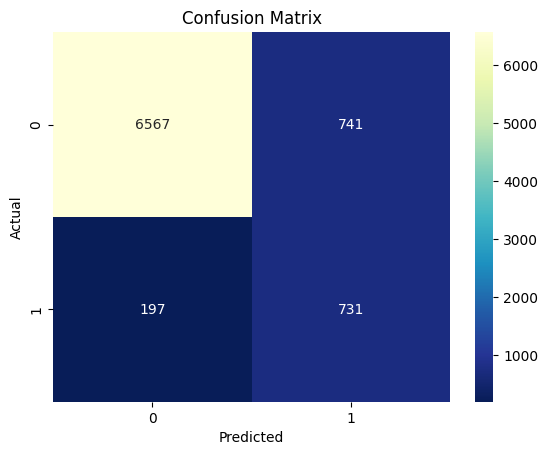

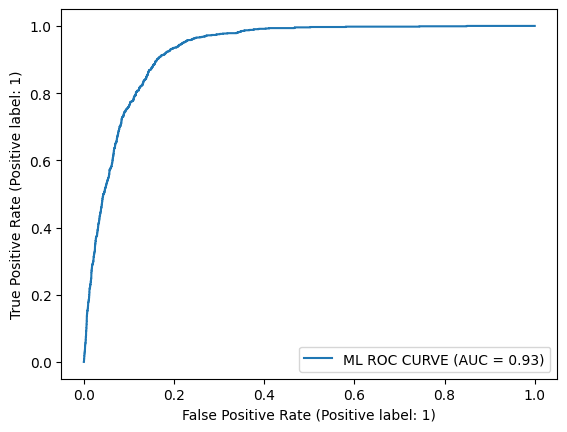

Split 1
0  precision, recall, f1score :  (0.9426457195565483, 0.9445373595996343, 0.943272898489485, None)
0  roc_auc_score :  0.9827145781225999
validation : precision, recall, f1score macro :  (0.7335843418448285, 0.8173149288451013, 0.7651245606938426, None)
validation : roc_auc_score :  0.9044350752835816
Split 2
1  precision, recall, f1score :  (0.9714952617686458, 0.9696940669672427, 0.9704771200970984, None)
1  roc_auc_score :  0.9966033140899034
validation : precision, recall, f1score macro :  (0.7324282303292797, 0.8579809797482212, 0.772725911482163, None)
validation : roc_auc_score :  0.9333096081526149
Split 3
2  precision, recall, f1score :  (0.9694976714973154, 0.9655015001153858, 0.9670364866154939, None)
2  roc_auc_score :  0.9962615270472452
validation : precision, recall, f1score macro :  (0.7247670975740865, 0.8669694170771758, 0.7662563677524452, None)
validation : roc_auc_score :  0.9282163618519148


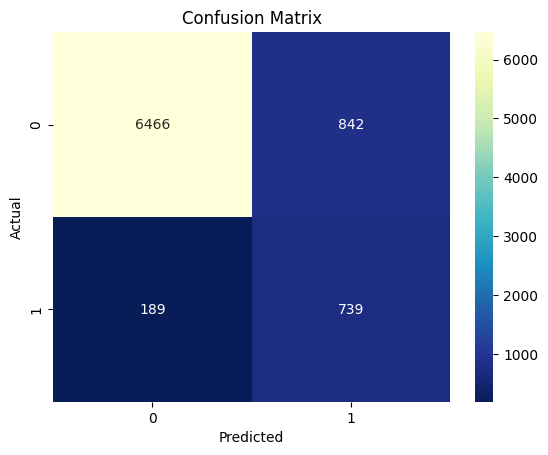

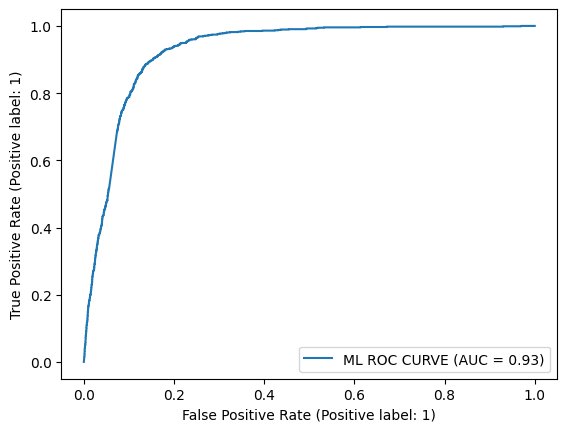

Split 1


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


0  precision, recall, f1score :  (0.9472931121334546, 0.949840963775668, 0.9476094783571918, None)
0  roc_auc_score :  0.9835213367984585
validation : precision, recall, f1score macro :  (0.7436038063094736, 0.7873563218390804, 0.7626762085678274, None)
validation : roc_auc_score :  0.8972397396334673
Split 2


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


1  precision, recall, f1score :  (0.9800076393813664, 0.9776472461369339, 0.978642372852244, None)
1  roc_auc_score :  0.9981947022980411
validation : precision, recall, f1score macro :  (0.7267384144765371, 0.83022030651341, 0.7624619335459385, None)
validation : roc_auc_score :  0.9267542183341826
Split 3
2  precision, recall, f1score :  (0.9757522982216562, 0.973032189290954, 0.9741536520545835, None)
2  roc_auc_score :  0.996942364108978
validation : precision, recall, f1score macro :  (0.7333992895525212, 0.8500701286261632, 0.7722754183536535, None)
validation : roc_auc_score :  0.926936470188551


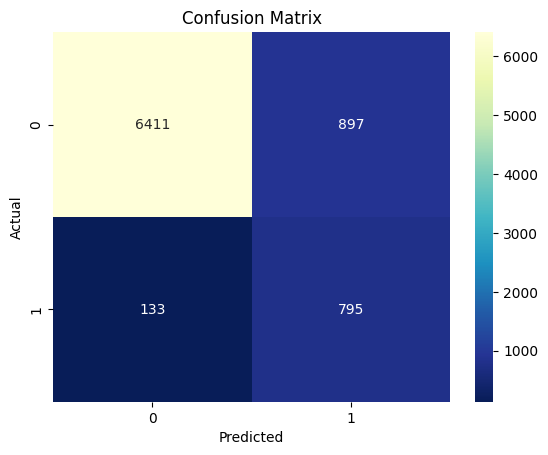

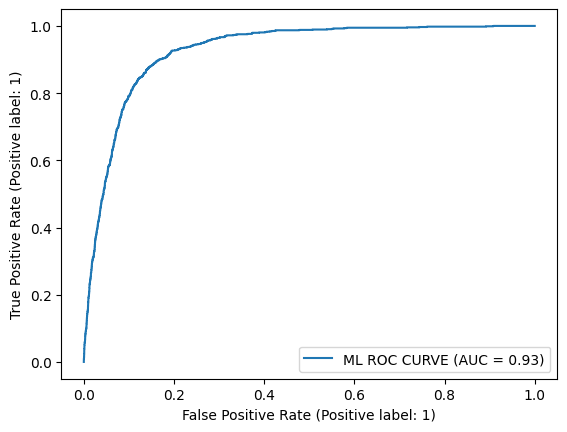

Split 1
0  precision, recall, f1score :  (0.9463443748615039, 0.9488941567316571, 0.946643206030868, None)
0  roc_auc_score :  0.9866127940048154
validation : precision, recall, f1score macro :  (0.7372518942035049, 0.7671729611384783, 0.7508363324401481, None)
validation : roc_auc_score :  0.9037346000132118
Split 2
1  precision, recall, f1score :  (0.9833702611386335, 0.9821180004342751, 0.9826852063055929, None)
1  roc_auc_score :  0.9980048237362414
validation : precision, recall, f1score macro :  (0.7276847285856937, 0.8111658456486043, 0.758847953669181, None)
validation : roc_auc_score :  0.9183578046260122
Split 3
2  precision, recall, f1score :  (0.9776441157191698, 0.9742989472775268, 0.975633984070142, None)
2  roc_auc_score :  0.9971915700590446
validation : precision, recall, f1score macro :  (0.7145806796000843, 0.8314603858784892, 0.7514817062696824, None)
validation : roc_auc_score :  0.9152475794122643


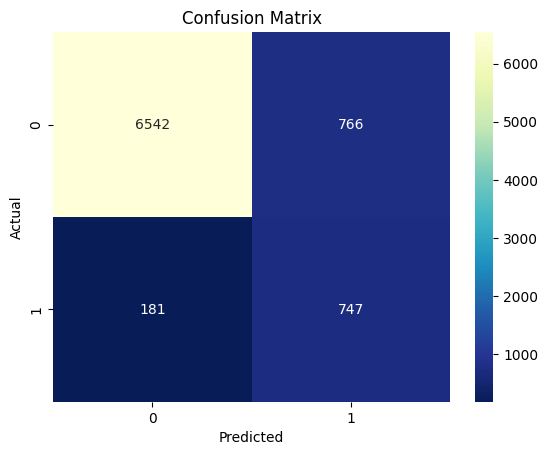

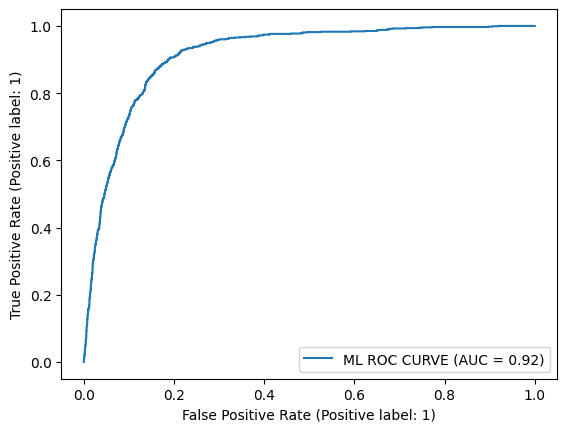

Split 1
0  precision, recall, f1score :  (0.9397543253857686, 0.9423338874544288, 0.9396430311860284, None)
0  roc_auc_score :  0.9880103165683677
validation : precision, recall, f1score macro :  (0.740619271276138, 0.7791461412151067, 0.7576628800234411, None)
validation : roc_auc_score :  0.9195339631344016
Split 2
1  precision, recall, f1score :  (0.9723772732522167, 0.9706206216325832, 0.9713868103888348, None)
1  roc_auc_score :  0.9968988002984673
validation : precision, recall, f1score macro :  (0.7383558514650077, 0.8569547071702244, 0.7780617866629537, None)
validation : roc_auc_score :  0.9330485426929392
Split 3
2  precision, recall, f1score :  (0.9688569605829289, 0.9678168732981263, 0.968293448164762, None)
2  roc_auc_score :  0.9961391595520159
validation : precision, recall, f1score macro :  (0.74075534198851, 0.8418685002736728, 0.7770154399871956, None)
validation : roc_auc_score :  0.9304164336909952


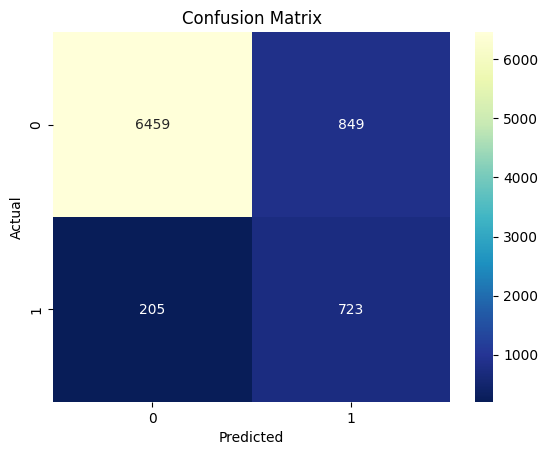

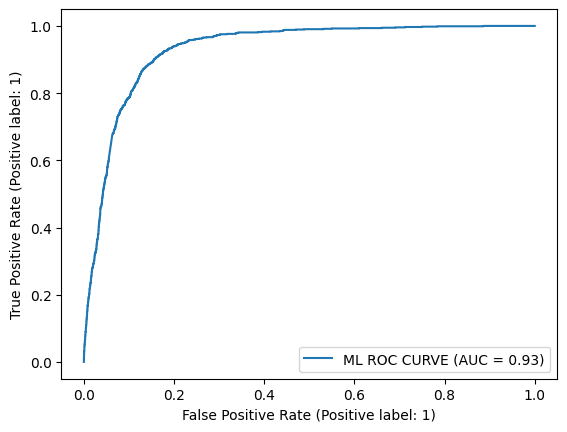

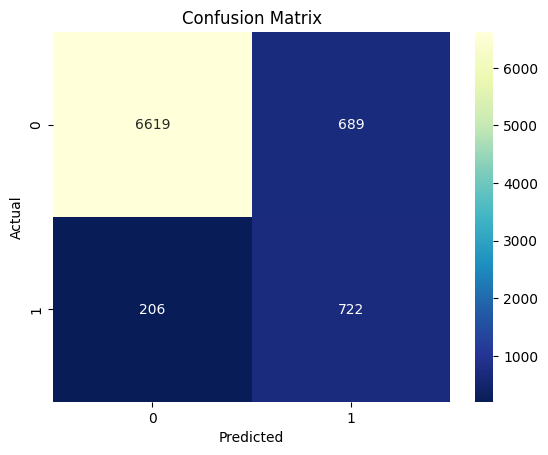

In [ ]:
for num_hidden_layer_sizes in [10, 20, 30]:
    for learning_rate_init in [0.002, 0.01, 0.1]:
        with mlflow.start_run():
            n_split = 3
            skf = StratifiedKFold(n_splits=n_split)
            skf.get_n_splits(X_base, Y_encoded)

            list_fold_result_test = []
            list_fold_result_validation = []
            list_fold_roc_test = []
            list_fold_roc_validation = []
            num_hidden_layer_sizes = num_hidden_layer_sizes
            activation = 'relu'
            learning_rate_init = learning_rate_init

            mlflow.log_param("split num", n_split)
            mlflow.log_param("hidden_layer_sizes", num_hidden_layer_sizes)
            mlflow.log_param("activation", activation)
            mlflow.log_param("learning_rate_init", learning_rate_init)
            mlflow.log_param("sampling", "SMOTEENN")
            for i, (train_index, test_index) in enumerate(skf.split(X_csm_sampling, y_csm_sampling)):
                print("Split " + str(i+1))
                X_train_cv, X_test_cv = X_csm_sampling.iloc[train_index, :], X_csm_sampling.iloc[test_index, :]
                y_train_cv, y_test_cv = y_csm_sampling[train_index], y_csm_sampling[test_index]

                # model set
                rf_clf = MLPClassifier(hidden_layer_sizes=num_hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate_init)
                rf_clf.fit(X_train_cv, y_train_cv)

                # model inference on test set
                y_prd_test = rf_clf.predict(X_test_cv)
                y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]

                # score evaluation on test set
                prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average='macro')
                score_test = roc_auc_score(y_test_cv, y_prd_proba_test, average='macro')
                print(i, " precision, recall, f1score : ", prf_score_test)
                print(i, " roc_auc_score : ", score_test)
                list_fold_roc_test.append(score_test)
                list_fold_result_test.append(prf_score_test)

                # model inference on validation data set
                y_prd_validation = rf_clf.predict(X_validation)
                y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:,-1]

                # score evaluation on validation data set
                prf_score_validation_macro = precision_recall_fscore_support(y_validation, y_prd_validation, average='macro')
                score_validation = roc_auc_score(y_validation, y_prd_proba_validation, average='macro')
                print("validation : precision, recall, f1score macro : ", prf_score_validation_macro)
                print("validation : roc_auc_score : ", score_validation)
                list_fold_roc_validation.append(score_validation)
                list_fold_result_validation.append(prf_score_validation_macro)


            def get_prf_average(list_of_result):
                pre = 0
                rec = 0
                f1 = 0
                for result in list_fold_result_validation:
                    pre += result[0]
                    rec += result[1]
                    f1 += result[2]
                return pre/n_split, rec/n_split, f1/n_split

            pre, rec, f1 = get_prf_average(list_fold_result_test)
            pre_val, rec_val, f1_val = get_prf_average(list_fold_result_validation)

            roc = sum(list_fold_roc_test)/n_split
            roc_val = sum(list_fold_roc_validation)/n_split

            mlflow.log_metric("precision_on_test", pre)
            mlflow.log_metric("recall_on_test", rec)
            mlflow.log_metric("f1score_on_test", f1)
            mlflow.log_metric("roc_on_test", roc)


            mlflow.log_metric("precision_on_validation", pre_val)
            mlflow.log_metric("recall_on_validation", rec_val)
            mlflow.log_metric("f1score_on_validation", f1_val)
            mlflow.log_metric("roc_on_validation", roc_val)


            def save_artifact(model, X_validation, y_validation, y_pred):
                roc_plot = RocCurveDisplay.from_estimator(model,X_validation,y_validation,name='ML ROC CURVE')
                plt.savefig('model_roc_plot.png')
                plt.show()
                plt.clf()
                conf_matrix = confusion_matrix(y_validation, y_pred)
                ax=sns.heatmap(conf_matrix,annot=True,fmt='g',cmap='YlGnBu_r')
                plt.ylabel('Actual')
                plt.xlabel('Predicted')
                plt.title("Confusion Matrix")
                plt.savefig('model_conf_matrix.png')
                mlflow.log_artifact('model_roc_plot.png')
                mlflow.log_artifact('model_conf_matrix.png')
            save_artifact(rf_clf, X_validation, y_validation, y_prd_validation)
            mlflow.sklearn.log_model(rf_clf, "model")


        mlflow.end_run()


### 4.7 Model Metrics

##### Confusion Matrix 리뷰


*   Model 성능을 측정하기 위해 Model에 의해 예측된 값고 실제 값을 비교하기 위한 표(Matrix)
*   해당 값을 활용해 Accuracy, Precision, Recall, F1score 등을 계산할 수 있다.



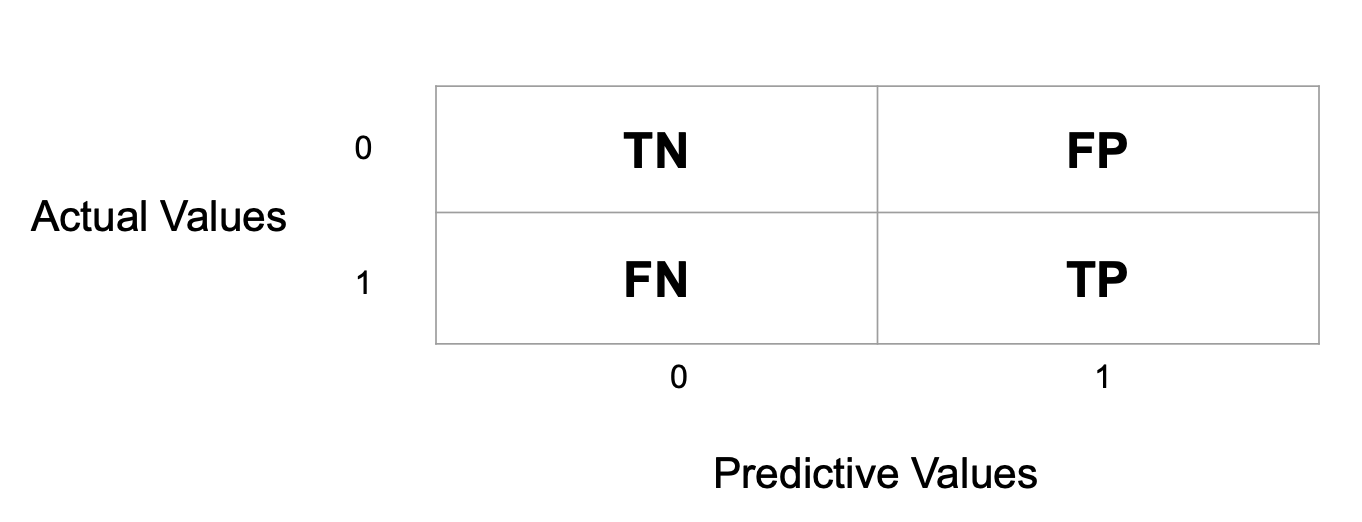

In [ ]:
Image(path_lecture+"/img/confusion_matrix.png")



*   Accuracy(정확도) = (TP+TN)/(TP+FN+FP+TN))
*   Precision(정밀도) = (TP)/(TP+FP)
*   Recall(재현도) = (TP)/(TP+FN)
*   F1 Score  = Precision과 Recall의 조화평균 = (2 * Precision * Recall)/(Precision+Recall)




In [ ]:
tn, fp, fn, tp = confusion_matrix(y_validation,y_prd_validation).ravel()
print(tn, fp, fn, tp)
accuracy = (tp+tn)/(tp+fn+fp+tn)
precision =  tp/(tp+fp)
recall = tp/(tp+fn)
print("accuracy ", accuracy)
print("precision ", precision)
print("recall ", recall)
print("f1score ", 2*precision*recall/(precision+recall))

6632 676 211 717
accuracy  0.8923020883924235
precision  0.5147164393395549
recall  0.7726293103448276
f1score  0.6178371391641534


### 4.8 Model Analysis

##### Shapley Value
*   게임 이론에 근거해서 만들어진 값 (https://ko.wikipedia.org/wiki/게임이론)
*   하나의 특성에 대한 중요도를 알기위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 변화를 분석해서 얻어낸 값
*.  Explainable AI
*   https://en.wikipedia.org/wiki/Shapley_value



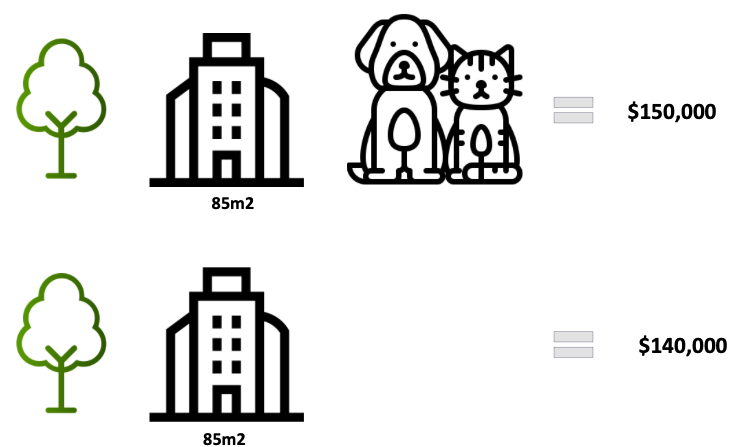

In [ ]:
Image(path_lecture + "img/shapley_value.png")

In [ ]:
#reproduction
mlp_final = MLPClassifier(**{'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': 20, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'})
mlp_final.fit(X_sm_sampling, y_sm_sampling)


MLPClassifier(early_stopping=True, hidden_layer_sizes=20, max_iter=10000)

In [ ]:
explainer = shap.Explainer(lambda x : mlp_final.predict_log_proba(x)[:,1], X_validation)
shap_values = explainer(X_validation)

Permutation explainer: 8237it [04:42, 28.64it/s]                          


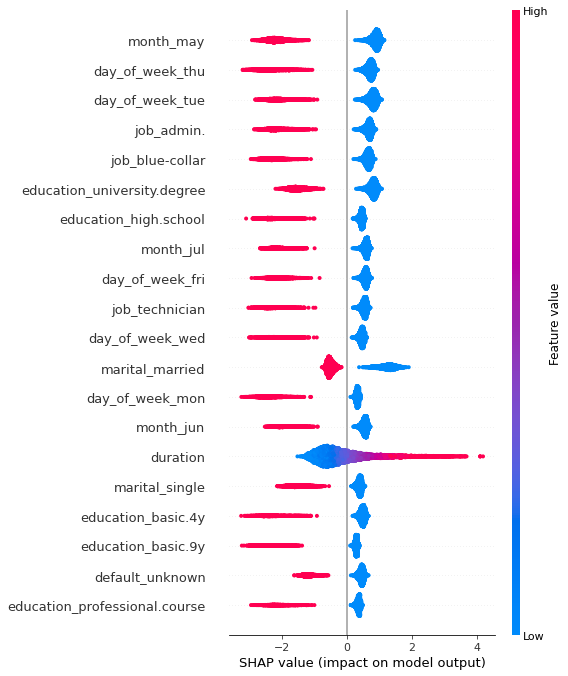

In [ ]:
shap.summary_plot(shap_values, X_validation)

## 5. Model Deploy

### 5-1. Model Inference

In [ ]:
model_uri = "models:/bank_marketing/Production"
loaded_model = mlflow.sklearn.load_model(model_uri)

In [ ]:
y_prd = loaded_model.predict(pd.DataFrame(X_validation))

In [ ]:
precision_recall_fscore_support(y_validation, y_prd, average='macro')

(0.7597015527305362, 0.8304341133004927, 0.7884647433906796, None)

### 5-2. MLFlow 를 이용한 API Serving

### serving하려는 model의 path를 찾아 입력한 뒤에, terminal에서 아래 명령어를 실행해야함  (실행은 본 실습을 진행한 경로에서 진행)

In [ ]:
# mlflow models serve -m ./mlartifacts/725520555070266145/970f70d6e602496ead48c2674378becd/artifacts/model -p 5001 --no-conda

In [ ]:
import pandas as pd
import requests

# Define local host and endpoint url
host = "127.0.0.1"
url = f"http://{host}:5001/invocations"

# Create dictionary with pandas DataFrame in the split orientation
json_data = {"dataframe_split": X_validation[:10].to_dict(orient="split")}

# Score model
response = requests.post(url, json=json_data)
print(f"\nPyfunc 'predict_interval':\n${response.json()}")



Pyfunc 'predict_interval':
${'predictions': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
